<h1 style="text-align: center;">Sleeping score / Regression V1</h1>

<h1 style="text-align: center;"><a id="table_contents">Table of contents</a></h1>
<ul>
<h3><li><a href="#introduction">1. Introduction</a></li></h3>
<h3><li><a href="#data_wrangling">2. Data Wrangling</a></li></h3>
    <ul>
        <h4><li><a href="#dataset_explanations">2.1. Dataset explanations</a></li></h4>
        <h4><li><a href="#data_preprocessing">2.2. Data preprocessing</a></li></h4>
    </ul>
<h3><li><a href="#eda">3. Exploratory Data Analysis</a></li></h3>
<h3><li><a href="#modeling">4. Modeling</a></li></h3>
<h3><li><a href="#conclusion">5. Conclusion</a></li></h3>
</ul>

In [132]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from functions import *

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_regression, RFE

from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold, KFold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
mlflow.set_experiment("Sleeping_score")

mlflow.set_tracking_uri(uri="http://127.0.0.1:8888")

Do 1 model of regression to predict sleeping score (classic ML + NN)

And 1 model of classification to predict quality score (try to build a solid neural network)

<a id='introduction'></a>
# 1. Introduction 
<a href="#table_contents">Table of contents</a>
<hr>
This machine learning project leverages four datasets sourced from a friend's Garmin Connect account.    

The datasets include daily records of sports activities, heart rate, calories consumption, and nightly sleep data. The goal of the project is to predict a sleeping score, on a scale from 0 to 100, using the provided data.

By analyzing patterns and correlations between physical activities, max heart rate during the day, calories consumed and sleep quality, the model aims to offer insights into factors that most significantly impact sleep. The predictive model will aid in optimizing lifestyle choices to enhance overall sleep quality.
<hr>

## 1.1 Dataset explanations <a id='dataset_explanations'></a>

<h4><b><u>Activities Dataset :</u></b></h4>

- <u>Type</u> : Activity type, e.g. running, cycling, swimming, etc...
- <u>Date</u> : Date of the activity
- <u>Activity_distance</u> : Distance of the activity in kilometers (or meters for swimming)
- <u>Activity_calories</u> : Calories consumed during activity
- <u>Duration</u> : Total duration of the activity (hh:mm:ss)
- <u>Activity_average_heart_rate</u> : Average heart rate during the activity
- <u>Activity_maximum_heart_rate</u> : Maximum heart rate reached during the activity
- <u>Aerobic</u> TE : As provided by Garmin, the training effect is a measure that provides informations about the effect on our physicial condition. 
    This Training Effect is between 0 and 5, with :
    - 0 to 0.9 : No improvement
    - 1 to 1.9 : Little improvement
    - 2 to 2.9 : Maintain
    - 3 to 3.9 : Improvement
    - 4 to 4.9 : Great improvement
    - 5 : Objective exceeded
- <u>Average_running_cadence</u> : Only presents in running activity, represent the average steps by minutes
- <u>Maximum_running_cadence</u> : Only presents in running activity, represent the maximum steps by minutes reached
- <u>Average_pace</u> : Average pace during the activity. 
    - min/km for running
    - km/h for cycling
    - min/100m for swimming
- <u>Best_pace</u> : Best pace reached during the activity.
- <u>Maximum_temperature</u> : Maximum outside temperature recorded by the watch during the activity.
- <u>Activity_minimum_respiratory_frequency</u> : Minimum respiratory frequency recorded during activity. In breathing/minutes.
- <u>Activity_average_respiratory_frequency</u> : Average respiratory frequency recorded during activity. In breathing/minutes.
- <u>Activity_maximum_respiratory_frequency</u> : Maximum respiratory frequency recorded during activity. In breathing/minutes.
- <u>Travel_time</u> : Time spent in movement during the activity (hh:mm:ss)
- <u>Elapsed_time</u> : Total time of the activity (hh:mm:ss)
- <u>Minimum_altitude</u> : Minimum altitude recorded by the watch during the activity.
- <u>Maximum_altitude</u> : Maximum altitude recorded by the watch during the activity.
<hr>
<h4><b><u>Calories Dataset :</u></b></h4>

- <u>Date</u> : Date associated
- <u>Active_calories</u> : Calories consumed in activity
- <u>Resting_calories</u> : Base calories consumption of the body
- <u>Total_calories</u> : Total calories consumed during the day, sum of the active calories and resting calories.
<hr>
<h4><b><u>Heart rate Dataset :</u></b></h4>

- <u>Date</u> : Date associated
- <u>Resting_HR</u> : Heart rate when the body is at rest, usually when we are sleeping or lying in bed after waking up. <a style="color: rgb(255,0,0)"><b>This variable is automatically eliminated as it is recorded during sleep.</b></a>
- <u>Highest_HR</u> : Highest reached heart rate of the day.
<hr>
<h4><b><u>Sleep Dataset</u></b></h4>

- <u>Score</u> : Represents a sleeping score on a scale from 0 to 100, that represents how well we slept.
- <u>Date</u> : Wake-up date. Meaning that all the other dataset are shifted by one day in relation to this dataset.
- <u>Base_HR</u> : Heart rate when the body is at rest, usually when we are sleeping or lying in bed after waking up.
- <u>HRV</u> (Heart Rate Variability) : The HRV represents the variation in time between consecutive heartbeats.  HRV is a great indicator of the balance between the activity of the two branches of the autonomic nervous system. It is an indirect measurement of stress, higher HRV means lower stress. It is also used to determine sleep stages. (source : https://support.garmin.com/en-US/?faq=04pnPSBTYSAYL9FylZoUl5)
- <u>Quality</u> : The quality is highly related to score as it is bins of the latter.
    - Poor : 0 - 59
    - Fair : 60 - 79
    - Good : 80 - 89
    - Excellent : 90 - 100
- <u>Sleep_duration</u> : Time spent sleeping.
- <u>Bedtime</u> : Time we fell asleep. (hh:mm)
- <u>Waking_hour</u> : Wake-up time. (hh:mm)  <a style="color: rgb(255,0,0)"><b>This variable is automatically eliminated as it is a result of sleep.</b></a>

# 2. Data Wrangling <a id='data_wrangling'></a>
<a href="#table_contents">Table of contents</a>

In [3]:
activities_vars = ["Type d'activité", "Date", "Distance", "Calories", "Durée", "Fréquence cardiaque moyenne", "Fréquence cardiaque maximale",
                   "TE aérobie", "Cadence de course moyenne", "Cadence de course maximale", "Allure moyenne", "Meilleure allure",
                   "Température maximale", "Fréquence respiratoire moyenne", "Fréquence respiratoire minimale", "Fréquence respiratoire maximale",
                   "Temps de déplacement", "Temps écoulé", "Altitude minimale", "Altitude maximale"]

activities_vars_eng = ["Type", "Date", "Activity_distance", "Activity_calories", "Duration", "Activity_average_heart_rate", "Activity_maximum_heart_rate",
                       "Aerobic_TE", "Average_running_cadence", "Maximum_running_cadence", "Average_pace", "Best_pace",
                       "Maximum_temperature", "Activity_average_respiratory_frequency", "Activity_minimum_respiratory_frequency", "Activity_maximum_respiratory_frequency",
                       "Travel_time", "Elapsed_time", "Minimum_altitude", "Maximum_altitude"]

In [4]:
activities_vars_rename = dict(zip(activities_vars, activities_vars_eng))

In [5]:
# Import activities data and rename variables in english
activities = pd.read_csv("Data/Activities.csv", sep=",", header=0, encoding="utf8", na_values='--')
activities = activities[activities_vars]
activities = activities.rename(columns=activities_vars_rename)
print(activities.shape)
activities.head(3)

(380, 20)


,Type,Date,Activity_distance,Activity_calories,Duration,Activity_average_heart_rate,Activity_maximum_heart_rate,Aerobic_TE,Average_running_cadence,Maximum_running_cadence,Average_pace,Best_pace,Maximum_temperature,Activity_average_respiratory_frequency,Activity_minimum_respiratory_frequency,Activity_maximum_respiratory_frequency,Travel_time,Elapsed_time,Minimum_altitude,Maximum_altitude
0,Course à pied,2024-05-09 15:49:57,9.45,720,00:49:25,162,193,3.9,161.0,172.0,5:14,3:58,29.0,33.0,19.0,42.0,00:48:16,00:49:25,34.0,53
1,Course à pied,2024-05-08 18:40:10,7.33,522,00:43:53,133,151,2.5,159.0,190.0,5:59,5:04,26.0,26.0,14.0,34.0,00:43:24,00:43:54,45.0,58
2,Course à pied,2024-05-07 18:48:17,1.44,106,00:07:15.2,148,174,2.1,162.0,221.0,5:03,3:55,26.0,NaN,NaN,NaN,00:06:55.3,00:07:15.2,41.0,52


In [6]:
# Import calories data and rename variables in english
calories = pd.read_csv("Data/Calories_pv.csv", sep=";", header=0, encoding="latin1")
calories = calories.rename(columns={"Calories actives": "Active_calories",
                                    "Calories au repos": "Resting_calories",
                                    "Calories dépensées au total": "Total_calories"})
print(calories.shape)
calories.head(3)

(487, 4)


,Date,Active_calories,Resting_calories,Total_calories
0,15 Avr.,772,"1,837","2,609"
1,14 Avr.,"1,491","2,187","3,678"
2,13 Avr.,620,"2,187","2,807"


In [7]:
# Import heart rate data and rename variables in english
hr = pd.read_csv("Data/FC.csv", sep=";", header=0, encoding="utf8", na_values="--")
hr = hr.rename(columns={"Repos": "Resting_HR",
                        "Le plus haut": "Highest_HR"})
print(hr.shape)
hr.head(3)

(470, 3)


,Date,Resting_HR,Highest_HR
0,16 Avr.,52 bpm,69 bpm
1,15 Avr.,52 bpm,167 bpm
2,14 Avr.,61 bpm,142 bpm


In [8]:
# Import sleep data and rename variables in english
sleep = pd.read_csv("Data/Sommeil.csv", sep=",", header=0, encoding="utf8", na_values="--")

sleep_list = [pd.read_csv(f"Data/Sommeil ({idx}).csv", sep=",", header=0, encoding="utf8", na_values="--") for idx in range(1, 17+1)]
sleep_list.insert(0, sleep) # Put the latest data at the beginning of the list

sleep = pd.concat(sleep_list)
sleep = sleep.rename(columns={"Score de sommeil 4\xa0semaines": "Date",
                              "Fréquence cardiaque au repos": "Base_HR",
                              "Statut de la variabilité de la fréquence cardiaque": "HRV",
                              "Qualité": "Quality",
                              "Durée": "Sleep_duration",
                              "Heure de coucher": "Bedtime",
                              "Heure de lever": "Waking_hour"}).drop(columns="Oxymètre de pouls")

sleep = sleep[["Date", "Score", "Quality", "Sleep_duration", "Bedtime", "Waking_hour"]]

print(sleep.shape)
sleep.head(3)


(504, 6)


,Date,Score,Quality,Sleep_duration,Bedtime,Waking_hour
0,15 Avr.,89.0,Bon,8h 4min.,23:26,7:31
1,14 Avr.,41.0,Mauvais,7h 6min.,3:23,10:39
2,13 Avr.,74.0,Passable,8h 30min.,23:08,8:20


## 2.1. Data preprocessing <a id="data_preprocessing"></a>
<a href="#table_contents">Table of contents</a>

### Activities dataset

In [9]:
# Convert to datetime type the Date column
activities['Date'] = pd.to_datetime(activities['Date']).dt.date
activities['Date'] = pd.to_datetime(activities['Date']) # convert back to datetime64[ns] instead of float

In [10]:
activities.head(3)

,Type,Date,Activity_distance,Activity_calories,Duration,Activity_average_heart_rate,Activity_maximum_heart_rate,Aerobic_TE,Average_running_cadence,Maximum_running_cadence,Average_pace,Best_pace,Maximum_temperature,Activity_average_respiratory_frequency,Activity_minimum_respiratory_frequency,Activity_maximum_respiratory_frequency,Travel_time,Elapsed_time,Minimum_altitude,Maximum_altitude
0,Course à pied,2024-05-09,9.45,720,00:49:25,162,193,3.9,161.0,172.0,5:14,3:58,29.0,33.0,19.0,42.0,00:48:16,00:49:25,34.0,53
1,Course à pied,2024-05-08,7.33,522,00:43:53,133,151,2.5,159.0,190.0,5:59,5:04,26.0,26.0,14.0,34.0,00:43:24,00:43:54,45.0,58
2,Course à pied,2024-05-07,1.44,106,00:07:15.2,148,174,2.1,162.0,221.0,5:03,3:55,26.0,NaN,NaN,NaN,00:06:55.3,00:07:15.2,41.0,52


### Calories dataset

In [11]:
month_dict = {"jan.": 1, "fév.": 2, "mar.": 3, "avr.": 4, "mai": 5, "juin": 6, "juil": 7, "août": 8, "sep.": 9, "oct": 10, "nov.": 11, "déc.": 12}

In [12]:
def get_day(row, date_var, month_dict):
    """ Retrieve the day of the Date variables in the dataframes """

    if len(row[date_var].split('-')) > 1:
        splitted_date = row[date_var].split('-')
        day = splitted_date[0].lstrip('0')
        return day
    else:
        splitted_date = row[date_var].split(' ')
        day = splitted_date[0]
        return day
    

def get_month(row, date_var, month_dict):
    """ Retrieve the month number of the Date variables in the dataframes """
    
    if len(row[date_var].split('-')) > 1:
        splitted_date = row[date_var].split('-')
        month = month_dict[splitted_date[1].lower()]
        return month
    else:
        splitted_date = row[date_var].split(' ')
        month = month_dict[splitted_date[1].lower()]
        return month
    
def new_date(row):
    """ Use the newly created Year, Month and Day to create the new Date in Datetime64[ns] with format YYYY-MM-DD """
    
    return pd.to_datetime(f"{int(row['Year'])}-{str(row['Month']).zfill(2)}-{str(row['Day']).zfill(2)}")

In [13]:
# Initiailize columns
calories['Day'] = np.zeros(calories.shape[0])
calories['Month'] = np.zeros(calories.shape[0])
calories['Year'] = np.zeros(calories.shape[0])

calories['Day'] = calories.apply(lambda row: get_day(row, 'Date', month_dict), axis=1)
calories['Month'] = calories.apply(lambda row: get_month(row, 'Date', month_dict), axis=1)
# Manually set the years 
calories.loc[467:, 'Year'] = 2022
calories.loc[:102, 'Year'] = 2024

calories['Year'] = np.where(calories['Year'] == 0, 2023, calories['Year'])
calories["Date"] = calories.apply(lambda row: new_date(row), axis=1)

calories = calories.drop(columns=['Day', 'Month', 'Year'])

In [14]:
calories.head(3)

,Date,Active_calories,Resting_calories,Total_calories
0,2024-04-15,772,"1,837","2,609"
1,2024-04-14,"1,491","2,187","3,678"
2,2024-04-13,620,"2,187","2,807"


### HR Dataset

In [15]:
# Initiailize columns
hr['Day'] = np.zeros(hr.shape[0])
hr['Month'] = np.zeros(hr.shape[0])
hr['Year'] = np.zeros(hr.shape[0])

# Manually set the years
hr.loc[451:, 'Year'] = 2022
hr.loc[:99, 'Year'] = 2024
hr['Year'] = np.where(hr['Year'] == 0, 2023, hr['Year'])

hr['Month'] = hr.apply(lambda row: get_month(row, 'Date', month_dict), axis=1)
hr['Day'] = hr.apply(lambda row: get_day(row, 'Date', month_dict), axis=1)

# Create the new date variable
hr["Date"] = hr.apply(lambda row: new_date(row), axis=1)

hr = hr.drop(columns=['Day', 'Month', 'Year'])

In [16]:
hr.head(3)

,Date,Resting_HR,Highest_HR
0,2024-04-16,52 bpm,69 bpm
1,2024-04-15,52 bpm,167 bpm
2,2024-04-14,61 bpm,142 bpm


### Sleep dataset

In [17]:
# The first 15 days the watch didn't record any score
sleep = sleep.reset_index(drop=True).loc[:len(sleep)-15, :] 

# We remove rows where we don't have a sleeping score as we won't be able to use them further.
sleep = sleep.loc[sleep['Score'].notna(), :].reset_index(drop=True)

In [18]:
# Create 3 new columns that receive Day, Month and Year of the Date column
sleep['Day'] = np.zeros(sleep.shape[0])
sleep['Month'] = np.zeros(sleep.shape[0])
sleep['Year'] = np.zeros(sleep.shape[0])

sleep.loc[:87, 'Year'] = 2024
sleep.loc[389:, 'Year'] = 2022

# If year is still 0 then it is 2023
sleep['Year'] = np.where(sleep['Year'] == 0, 2023, sleep['Year'])

# Retrieve Month and Day from the Date
sleep['Month'] = sleep.apply(lambda row: get_month(row, 'Date', month_dict), axis=1)
sleep['Day'] = sleep.apply(lambda row: get_day(row, 'Date', month_dict), axis=1)

# Convert Date to the wanted datetime format
sleep["Date"] = sleep.apply(lambda row: new_date(row), axis=1)


In [19]:
# sleeping score for a day correspond do the night from day-1 to day.
# Night of 15th of April is a result of activities of 14th of April
# So to compare effects of activities of the day we have to substract one day to every sleep data
sleep['Date'] = sleep['Date'] - pd.Timedelta(days=1)

sleep = sleep.drop(columns=['Day', 'Month', 'Year'])

## 2.2 Merged dataframes

In [20]:
merged_1 = pd.merge(sleep, activities, how='left', on='Date')
merged_2 = pd.merge(merged_1, hr, how='left', on='Date')
df_merged = pd.merge(merged_2, calories, how='left', on='Date').drop(columns=['Resting_HR'])

In [21]:
df_merged.head(3)

,Date,Score,Quality,Sleep_duration,Bedtime,Waking_hour,Type,Activity_distance,Activity_calories,Duration,...,Activity_minimum_respiratory_frequency,Activity_maximum_respiratory_frequency,Travel_time,Elapsed_time,Minimum_altitude,Maximum_altitude,Highest_HR,Active_calories,Resting_calories,Total_calories
0,2024-04-14,89.0,Bon,8h 4min.,23:26,7:31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,142 bpm,"1,491","2,187","3,678"
1,2024-04-13,41.0,Mauvais,7h 6min.,3:23,10:39,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,126 bpm,620,"2,187","2,807"
2,2024-04-12,74.0,Passable,8h 30min.,23:08,8:20,Course à pied,3.00,217,00:20:28,...,NaN,NaN,00:20:03,00:20:28,40.0,52,152 bpm,607,"2,187","2,794"


In [22]:
# Label Encoding on quality
print(f"Quality missing values : {df_merged['Quality'].isnull().mean()}")

qualities = [['Mauvais', 'Passable', 'Bon', 'Excellent']]

quality_OE = OrdinalEncoder(categories=qualities)
quality_OE.fit(np.array(df_merged['Quality']).reshape(-1, 1))

df_merged['Quality'] = quality_OE.transform(np.array(df_merged['Quality']).reshape(-1, 1))

Quality missing values : 0.0


In [23]:
for qual, number in zip(quality_OE.categories_[0] ,quality_OE.transform(np.array(quality_OE.categories_).reshape(-1, 1))):
    print(f"{qual} : {number[0]}")

Mauvais : 0.0
Passable : 1.0
Bon : 2.0
Excellent : 3.0


In [24]:
def sleep_duration_in_hours_minutes(row):
    """ Convert sleep duration from xh ymin. to hours,minutes """

    if not isinstance(row['Sleep_duration'], (int, float)):
        h, minutes = row['Sleep_duration'].split(' ')
        return float(h.strip('h')) + float(minutes.strip('min.')) / 60

def bed_related_to_minutes(row, bed_col):
    """ Convert bed related columns from hh:mm to hours,minutes """
    
    if not isinstance(row[bed_col], float):
        h, minutes = row[bed_col].split(':')
        return float(h) + float(minutes) / 60

In [25]:
# Convert sleep duration in minutes
print(f"Sleep duration missing values : {df_merged['Sleep_duration'].isnull().mean()}")

df_merged['Sleep_duration'] = df_merged.apply(lambda row: sleep_duration_in_hours_minutes(row), axis=1)

# Remove rows where Bedtime is NaN, as we further compute a sleeping duration variable
df_merged = df_merged.loc[df_merged['Bedtime'].notna()].reset_index(drop=True)
print(f"Bedtime missing values : {df_merged['Bedtime'].isnull().mean()}")

df_merged['Bedtime'] = df_merged.apply(lambda row: bed_related_to_minutes(row, 'Bedtime'), axis=1)
df_merged['Waking_hour'] = df_merged.apply(lambda row: bed_related_to_minutes(row, 'Waking_hour'), axis=1)

Sleep duration missing values : 0.0
Bedtime missing values : 0.0


In [26]:
# Initialize the new Awake time variable
df_merged['Awake_time'] = np.NaN

# Calculate the awake time be computing the difference between the Waking_hour of day d-1 and the bedtime of day d
for i in range(1, len(df_merged)):
    waking_prev_day = df_merged.at[i-1, 'Waking_hour']
    bedtime_curr_day = df_merged.at[i, 'Bedtime']
    # If the bedtime is after midnight we add 24
    if 0 < bedtime_curr_day < 10:
        bedtime_curr_day += 24
    df_merged.at[i, 'Awake_time'] = np.abs(waking_prev_day - bedtime_curr_day)

df_merged['Awake_time'] = np.where(pd.isna(df_merged['Awake_time']), df_merged['Awake_time'].mean(), df_merged['Awake_time'])

In [27]:
# Type selections and label encoding
df_merged['Type'] = np.where(pd.isna(df_merged['Type']), 'No_activities', df_merged['Type'])
type_part = df_merged['Type'].value_counts(dropna=False).reset_index()

In [28]:
type_part

,Type,count
0,Course à pied,234
1,No_activities,184
2,Cyclisme,17
3,Musculation,14
4,Nat. piscine,7
5,Marche à pied,4
6,Rameur d'intérieur,1
7,Randonnée,1


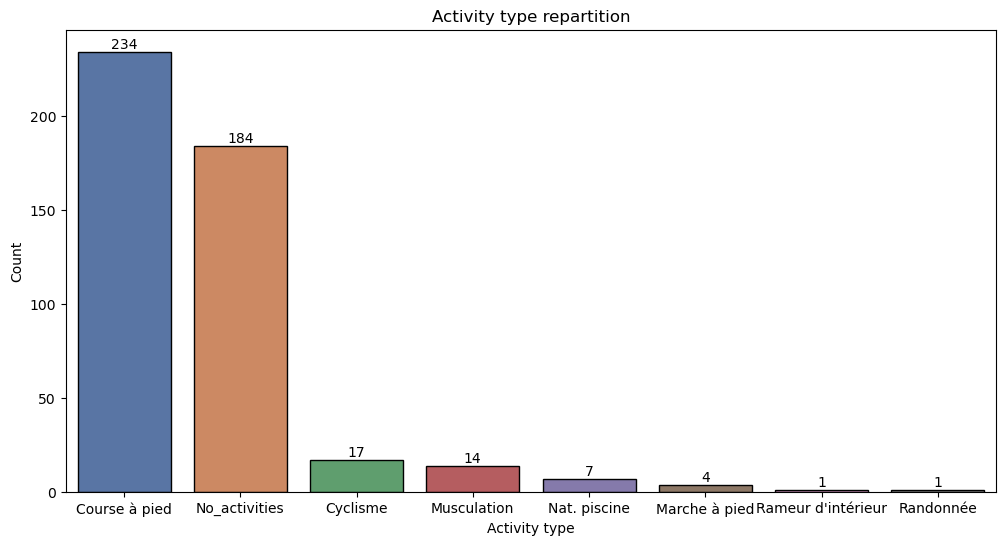

In [29]:
plt.figure(figsize=(12, 6))
bars = sns.barplot(data=type_part, x='Type', y='count', edgecolor='black', palette='deep')
plt.title("Activity type repartition")
plt.xlabel("Activity type")
plt.ylabel("Count")

for bar in bars.patches:
    height = bar.get_height()
    bars.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.show()

Thanks to the above plot, I choose to erase the following activities as they represents nothing : walk (Marche à pied), Indoor rower (Rameur d'intérieur) and Hiking (Randonnée).

I replace them by a "No_activities" 

In [30]:
to_remplace_types = ["Marche à pied", "Rameur d'intérieur", "Randonnée"]

df_merged['Type'] = np.where(df_merged['Type'].isin(to_remplace_types), 'No_activities', df_merged['Type'])

In [31]:
def convert_distance(row):
    """ Convert distance from string to float, with a results expressed in km """
    
    if row['Activity_distance'] != 0:
        # If activity is swimming and less than 1km were swimmed
        if row['Type'] == 'Nat. piscine' and not "," in row['Activity_distance']:
            return float(row['Activity_distance']) / 1000
        
        if "," in row['Activity_distance']:
            return float(row['Activity_distance'].replace(",", "."))
        
        return float(row['Activity_distance'])
    return 0

In [32]:
# Replace missing values by 0
df_merged['Activity_distance'] = np.where(pd.isna(df_merged['Activity_distance']), 0, df_merged['Activity_distance'])

df_merged['Activity_distance'] = df_merged.apply(lambda row: convert_distance(row), axis=1)

print(f"Activity distance missing values : {df_merged['Activity_distance'].isnull().mean()}")

Activity distance missing values : 0.0


In [33]:
def convert_calories(row, cal_var):
    """ Convert calories to integers """
    
    if not pd.isna(row[cal_var]) and not isinstance(row[cal_var], (float, int)):
        # handles cases where the calories finish by a 0 and the 0 is therefore truncated
        # So we have to append 0 at the end while the calories is not format 1,234
        if "," in row[cal_var] and len(row[cal_var]) != 5:
            while len(row[cal_var]) < 5:
                row[cal_var] += '0'

        # if there is a coma in calories meaning that it is greater than 1 000 then we delete
        # the coma. In the case where calories < 1000 where there's no coma, it's still transformed in integer
        return int(row[cal_var].replace(",", ""))
    
    return 0

In [34]:
calories_cols = ['Activity_calories', 'Active_calories', 'Resting_calories', 'Total_calories']  

# Replace by 0 rows where there is no activity and therefore no activity calories
df_merged['Activity_calories'] = np.where(pd.isna(df_merged['Activity_calories']), 0, df_merged['Activity_calories'])

for col in calories_cols:
    df_merged[col] = df_merged.apply(lambda row: convert_calories(row, col), axis=1)
    print(f"{col} missing values : {df_merged[col].isnull().mean()}")

# Handle cases where total calories is perfectly round like 3000
df_merged['Total_calories'] = np.where(df_merged['Total_calories'] <= 9, df_merged['Total_calories'] * 1000, df_merged['Total_calories'])

Activity_calories missing values : 0.0
Active_calories missing values : 0.0
Resting_calories missing values : 0.0
Total_calories missing values : 0.0


In [35]:
def durations_to_minutes(row, duration_var):
    """ Convert columns that represents a duration in minutes """
    
    if not pd.isna(row[duration_var]):
        h, m, s = row[duration_var].split(':')
        return int(h) * 60 + int(m) + float(s) / 60
    return 0

In [36]:
durations_cols = ['Duration', 'Travel_time', 'Elapsed_time']

for col in durations_cols:
    df_merged[col] = df_merged.apply(lambda row: durations_to_minutes(row, col), axis=1)
    print(f"{col} missing values : {df_merged[col].isnull().mean()}")

Duration missing values : 0.0
Travel_time missing values : 0.0
Elapsed_time missing values : 0.0


In [37]:
def pace_to_minutes_pace(row, pace_col):
    """ Convert pace to minutes,seconds / km """

    if not pd.isna(row[pace_col]):
        # For cycling the pace is expressed as km/h
        if row['Type'] == 'Cyclisme':
            return 60 / float(row[pace_col])
        
        # For swimming the pace is expressed as mm:ss / 100m
        elif row['Type'] == 'Nat. piscine':
            m, s = row[pace_col].split(':')
            return (int(m) + float(s) / 60) * 10

        else:
            m, s = row[pace_col].split(':')
            return int(m) + float(s) / 60
            
    return 0

In [38]:
pace_cols = ['Average_pace', 'Best_pace']

for col in pace_cols:
    df_merged[col] = df_merged.apply(lambda row: pace_to_minutes_pace(row, col), axis=1)

In [39]:
def convert_altitude(row):
    """ Convert altitude to integers """

    if not pd.isna(row['Maximum_altitude']):
        # Sometimes the watch records surprising altitude data, so we replace them by 0
        if int(row['Maximum_altitude'].replace(",", "")) < 0 or int(row['Maximum_altitude'].replace(",", "")) > 500:
            return 0
        
        else:
            return int(row['Maximum_altitude'])
        
    return 0

In [40]:
# Convert altitude
df_merged['Maximum_altitude'] = df_merged.apply(lambda row: convert_altitude(row), axis=1)
print(f"Maximum_altitude missing values : {df_merged['Maximum_altitude'].isnull().mean()}")

Maximum_altitude missing values : 0.0


In [41]:
def convert_HR(row, hr_col):
    """ Convert heart rate related columns to integers """
    
    if not pd.isna(row[hr_col]):

        return int(row[hr_col].strip(" bpm"))

In [42]:
hr_columns = ['Highest_HR']

for col in hr_columns:
    df_merged[col] = df_merged.apply(lambda row: convert_HR(row, col), axis=1)
    print(f"{col} missing values : {df_merged[col].isnull().mean()}")

Highest_HR missing values : 0.0021645021645021645


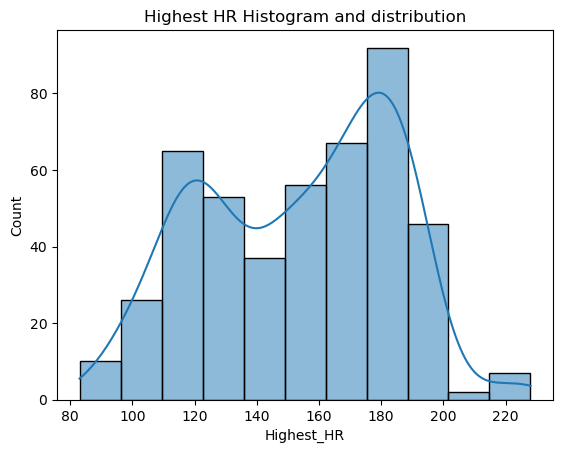

In [43]:
sns.histplot(data=df_merged, x='Highest_HR', kde=True)
plt.title('Highest HR Histogram and distribution')

plt.show()

In [44]:
# The Highest HR missing value represents 1 row so I've decided to remove it
df_merged = df_merged.loc[df_merged['Highest_HR'].notna()].reset_index(drop=True)

In [45]:
# Where there is no activity and therefore no aerobic TE, we replace NaN by 0
df_merged['Aerobic_TE'] = np.where(pd.isna(df_merged['Aerobic_TE']), 0, df_merged['Aerobic_TE'])

<hr>
When i merged the dataframe, I've initially done a left join on sleep dataset.

Sleep dataset contains **1 rows per date**, but the activities dataset contains 1 row <u>**per activity**</u>, so in the merged dataframe i've got multiples same sleeping data for one date but multiple activity for this date.

The following part handles 2 cases :

1. We have multiple activities for the same date, with at least 2 different activities
2. We have multiple activities for the same date, but it's the same activity that has been repeated

In both case we create a new variable that represents the number of different activities done this day, and we compute the sum for duration, distance and aerobic TE.

In [46]:
# Create a new dataframe that contains multiplied date
m_date = pd.DataFrame(df_merged['Date'].value_counts()).reset_index()
m_date = m_date.loc[m_date['count'] > 1]

In [47]:
# Create a dataframe that contains the number of unique activities, per date
unique_act = df_merged.groupby('Date')['Type'].nunique().reset_index()
# Contains date that have at least 2 different activities
mult_act = unique_act.loc[unique_act['Type'] > 1]

In [48]:
# Retrieve the date where there is at least 2 activity types
mult_act_date = [date for date in mult_act['Date'].tolist() if date in m_date['Date'].tolist()]
mult_act_date_n_type = mult_act['Type'].tolist()

# multiplied dates but that has multiplie activities of the unique same type
unique_act_date = [date for date in m_date['Date'] if date not in mult_act_date]

len(mult_act_date), len(unique_act_date)

(27, 8)

In [49]:
df_merged['N_activities'] = np.zeros(df_merged.shape[0])

# set N_activities for multiplied dates with at least 2 activity types
for idx, date in enumerate(mult_act_date):
    df_merged.loc[df_merged['Date'] == date, 'N_activities'] = mult_act_date_n_type[idx]

# Set N_activities for multiplied dates but with 1 activity type
for date in unique_act_date:
    df_merged.loc[df_merged['Date'] == date, 'N_activities'] = 1

In [50]:
# Where date are not mutliplied therefore we set n_activities to 1
df_merged['N_activities'] = np.where((df_merged['Type'] != 'No_activities') & (df_merged['N_activities'] == 0), 1, df_merged['N_activities'])

In [51]:
df_merged['Total_duration'] = np.zeros(df_merged.shape[0])
df_merged['Total_distance'] = np.zeros(df_merged.shape[0])
df_merged['Total_aerobic_TE'] = np.zeros(df_merged.shape[0])

In [52]:
# sums distance duration and aerobic TE for the multiple activities date
to_sum_cols = ['Activity_distance', 'Duration', 'Aerobic_TE']

for date in mult_act_date + unique_act_date:
    dist, dur, te = df_merged.loc[df_merged['Date'] == date, to_sum_cols].sum()
    df_merged.loc[df_merged['Date'] == date, 'Total_distance'] = dist
    df_merged.loc[df_merged['Date'] == date, 'Total_duration'] = dur
    df_merged.loc[df_merged['Date'] == date, 'Total_aerobic_TE'] = te

In [53]:
df_merged['Total_duration'] = np.where(df_merged['Total_duration'] == 0, df_merged['Duration'], df_merged['Total_duration'])
df_merged['Total_distance'] = np.where(df_merged['Total_distance'] == 0, df_merged['Activity_distance'], df_merged['Total_distance'])
df_merged['Total_aerobic_TE'] = np.where(df_merged['Total_aerobic_TE'] == 0, df_merged['Aerobic_TE'], df_merged['Total_aerobic_TE'])

In [54]:
# Now we keep only one row for the duplicated dates
df_merged = df_merged.drop_duplicates(subset='Date', keep='first').reset_index(drop=True)

In [55]:
to_drop_cols = ['Type', 'Duration', 'Activity_distance', 'Activity_calories', 'Average_pace', 'Best_pace', 'Maximum_temperature',
'Activity_minimum_respiratory_frequency', 'Travel_time', 'Elapsed_time', 'Active_calories', 'Resting_calories', 'Activity_average_heart_rate',
'Activity_maximum_heart_rate', 'Average_running_cadence', 'Maximum_running_cadence', 'Activity_average_respiratory_frequency',
'Activity_maximum_respiratory_frequency', 'Minimum_altitude', 'Maximum_altitude', 'Resting_HR', 'Aerobic_TE', 'Waking_hour']

In [56]:
miss_vals = df_merged.select_dtypes(include='number').isnull().mean()
miss_vals_cols = miss_vals[miss_vals > 0].index

for col in miss_vals_cols:
    df_merged[col] = np.where(pd.isna(df_merged[col]), 0, df_merged[col])

df_merged.isnull().mean()

Date                                      0.0
Score                                     0.0
Quality                                   0.0
Sleep_duration                            0.0
Bedtime                                   0.0
Waking_hour                               0.0
Type                                      0.0
Activity_distance                         0.0
Activity_calories                         0.0
Duration                                  0.0
Activity_average_heart_rate               0.0
Activity_maximum_heart_rate               0.0
Aerobic_TE                                0.0
Average_running_cadence                   0.0
Maximum_running_cadence                   0.0
Average_pace                              0.0
Best_pace                                 0.0
Maximum_temperature                       0.0
Activity_average_respiratory_frequency    0.0
Activity_minimum_respiratory_frequency    0.0
Activity_maximum_respiratory_frequency    0.0
Travel_time                       

In [57]:
quality_le = LabelEncoder()
quality_le.fit(df_merged['Type'].unique())

for sport, numb in zip(quality_le.classes_, quality_le.transform(['Course à pied', 'Cyclisme', 'Musculation', 'Nat. piscine', 'No_activities'])):
    print(f"{sport} : {numb}")

df_merged['Type'] = quality_le.transform(df_merged['Type'])

Course à pied : 0
Cyclisme : 1
Musculation : 2
Nat. piscine : 3
No_activities : 4


In [58]:
df_merged = df_merged.drop(columns=['Waking_hour'])

### Baseline model with all features

In [59]:
X_base = df_merged.drop(columns=['Date', 'Score', 'Quality'])
Y_base = df_merged['Score']

In [60]:
random_state = 42
test_size = 0.4

lr_base = LinearRegression()

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

base_cv_results = cross_validate(lr_base, X_base, Y_base, cv=skf, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'), return_train_score=True)

In [61]:
base_train_rmse_full = base_cv_results['train_neg_mean_squared_error']
base_test_rmse_full = base_cv_results['test_neg_mean_squared_error']

base_train_rmse = np.sqrt(np.abs(base_train_rmse_full)).mean()
base_test_rmse = np.sqrt(np.abs(base_test_rmse_full)).mean()

print(f"Base train RMSE : {base_train_rmse} | stddev : {np.std(base_train_rmse_full)}")
print(f"Base test RMSE : {base_test_rmse} | stddev : {np.std(base_test_rmse_full)}")

Base train RMSE : 10.880550890278275 | stddev : 5.725968208969817
Base test RMSE : 12.007048138448626 | stddev : 16.037090344051087


### Feature selection

#### SelectKBest
<hr>
The following cell runs the SelectKBest algorithm, starting by taking all the features and deleting them one by one.

Then, a plot shows the training and testing RMSE evolution based on the number of features

Finally, a correlation matrix is displayed to see how features interacts with each others.

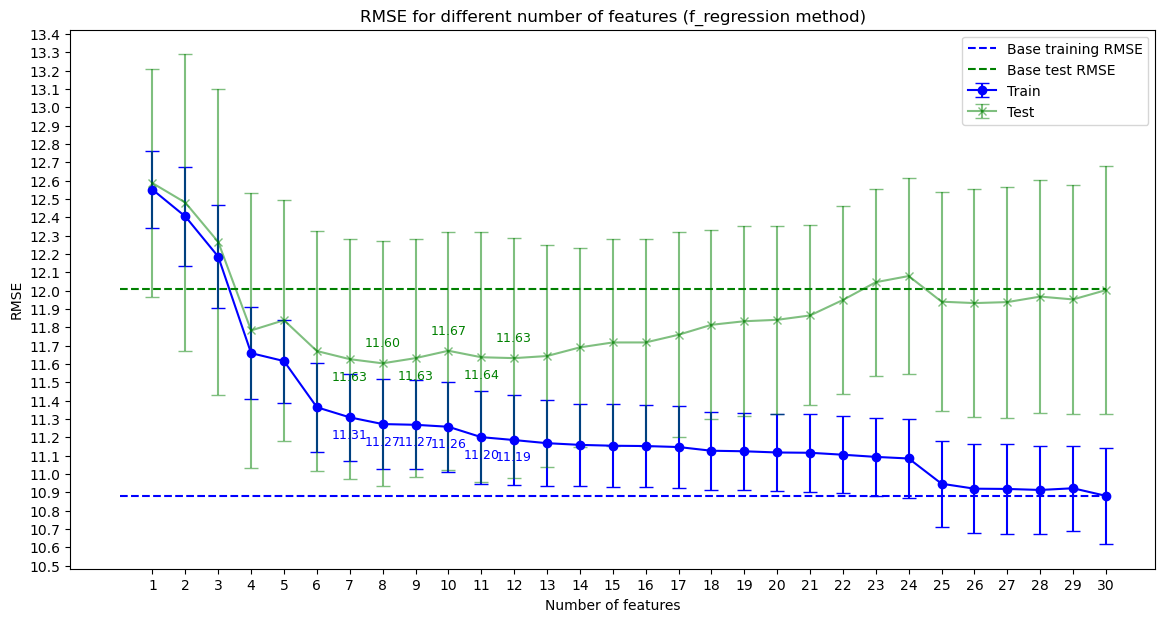

In [62]:
train_metric_means, test_metric_means = [], []
train_metric_stds, test_metric_stds = [], []
f_reg_k_best_features_dict = {}

random_state = 42
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

lr_test = LinearRegression()

max_features = X_base.shape[1]

for i in range(max_features, 0, -1):
    # INITIALISE KBest
    k = i
    kbest = SelectKBest(score_func=f_regression, k=k)
    kbest.fit(X_base, Y_base)
    
    # Create a dict with score, feature a key, values
    scores, features = kbest.scores_, kbest.feature_names_in_
    feature_score_dict = dict(zip(scores, features))

    k_best_feat_score = sorted(scores)[-k:]
    k_best_features = []

    # Retrieve the KBest feature names
    for score in k_best_feat_score:
        k_best_features.append(feature_score_dict[score])
    # Dictionnary that retrieve every set of features for each KBest 
    f_reg_k_best_features_dict[k] = k_best_features

    X_kbest = df_merged[k_best_features]
    Y_kbest = df_merged['Score']

    # Run a StratifiedKFold Cross Validation
    cv_results = cross_validate(lr_test, X_kbest, Y_kbest, cv=skf, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'), return_train_score=True)

    train_rmse_values = np.sqrt(np.abs(cv_results['train_neg_mean_squared_error']))
    test_rmse_values = np.sqrt(np.abs(cv_results['test_neg_mean_squared_error']))

    train_metric_means.append(train_rmse_values.mean())
    test_metric_means.append(test_rmse_values.mean())
    train_metric_stds.append(train_rmse_values.std())
    test_metric_stds.append(test_rmse_values.std())

plt.figure(figsize=(14, 7))
# plt.plot(range(max_features, 0, -1), train_metric_values, marker='o', label='Train', color='blue')
# plt.plot(range(max_features, 0, -1), test_metric_values, marker='x', label='Test', color='green')

plt.errorbar(range(max_features, 0, -1), train_metric_means, yerr=train_metric_stds, marker='o', label='Train', color='blue', capsize=5)
plt.errorbar(range(max_features, 0, -1), test_metric_means, yerr=test_metric_stds, marker='x', label='Test', color='green', capsize=5, alpha=0.5)

plt.hlines(y=base_train_rmse, xmin=0, xmax=max_features, linestyles='--', label='Base training RMSE', colors='blue')
plt.hlines(y=base_test_rmse, xmin=0, xmax=max_features, linestyles='--', label='Base test RMSE', colors='green')

plt.xlabel('Number of features')
plt.ylabel('RMSE')
plt.xticks([i for i in range(1, max_features+1, 1)])

y_min, y_max = min(min(train_metric_means), min(test_metric_means)), max(max(train_metric_means), max(test_metric_means))
steps = 0.1

plt.yticks(np.arange(10.5, 13.4 + steps, steps))

plt.title('RMSE for different number of features (f_regression method)')
plt.legend()

features_to_annotate = [7, 8, 9, 10, 11, 12]

for feature in features_to_annotate:
    index = max_features - feature
    test_neg = -1 if (feature % 2) else 0.8
    plt.annotate(f'{test_metric_means[index]:.2f}', 
                 (feature, test_metric_means[index]), 
                 textcoords="offset points", 
                 xytext=(0, test_neg * 15), 
                 ha='center', 
                 fontsize=9, 
                 color='green')
    plt.annotate(f'{train_metric_means[index]:.2f}', 
                 (feature, train_metric_means[index]), 
                 textcoords="offset points", 
                 xytext=(0,-15), 
                 ha='center', 
                 fontsize=9, 
                 color='blue')

plt.show()

#### Recursive Feature Elimination

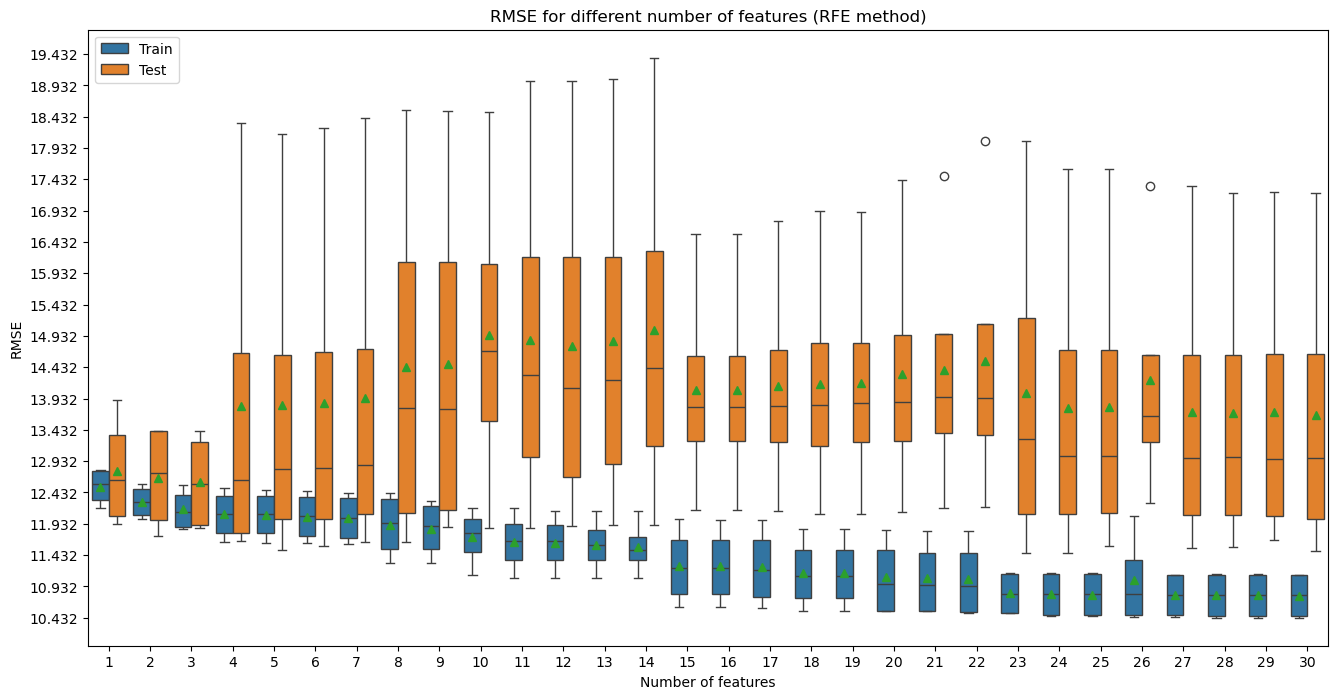

In [63]:
score_dict = {}
cv = 4
rmse_train_results, rmse_test_results, names = [], [], []

for i in range(1, X_base.shape[1]+1, 1):
    rfe_lr = LinearRegression()
    rfe = RFE(estimator=rfe_lr, n_features_to_select=i)
    

    scores_tmp = cross_validate(rfe, X_base, Y_base, scoring=('neg_mean_squared_error', 'r2'), cv=cv, n_jobs=-2, return_train_score=True)
    rmse_train_results.append(np.sqrt(np.abs(scores_tmp['train_neg_mean_squared_error'])))
    rmse_test_results.append(np.sqrt(np.abs(scores_tmp['test_neg_mean_squared_error'])))

    names.append(i)

train_results = []
for i, rmse_train in enumerate(rmse_train_results):
    for val in rmse_train:
        train_results.append({'Features': names[i], 'RMSE': val, 'Type': 'Train'})

test_results = []
for i, rmse_test in enumerate(rmse_test_results):
    for val in rmse_test:
        test_results.append({'Features': names[i], 'RMSE': val, 'Type': 'Test'})

results_df = pd.DataFrame(train_results + test_results)

# Plot using seaborn
plt.figure(figsize=(16, 8))
sns.boxplot(x='Features', y='RMSE', hue='Type', data=results_df, showmeans=True)
plt.xlabel('Number of features')
plt.ylabel('RMSE')
plt.title('RMSE for different number of features (RFE method)')

y_min, y_max = min(np.min(rmse_train_results), np.min(rmse_test_results)), max(np.max(rmse_train_results), np.max(rmse_test_results)) 
steps = 0.5

plt.yticks(np.arange(y_min, y_max + steps, steps))
plt.legend(loc='upper left')
plt.show()

In [64]:
k_features = 12

kbest = SelectKBest(score_func=f_regression, k=k_features)
kbest.fit(X_base, Y_base)

kbest_features = kbest.get_feature_names_out().tolist()

rfe_features = []

rfe_lr = LinearRegression()
rfe = RFE(estimator=rfe_lr, n_features_to_select=k_features)
rfe.fit(X_base, Y_base)

for sup, col in zip(rfe.support_, X_base.columns):
    if sup:
        rfe_features.append(col)


feat_select_dict = {"KBest_features": kbest_features, "RFE_features": rfe_features}

feat_select_df = pd.DataFrame(data=feat_select_dict)

def highlight_global(df):
    # Create a set of all features that appear in both columns
    common_features = set(df['KBest_features']).intersection(set(df['RFE_features']))
    
    # Initialize a DataFrame of the same shape as df with empty strings
    colors = pd.DataFrame('', index=df.index, columns=df.columns)
    
    # Apply colors based on whether the value is in the common_features set
    for col in df.columns:
        colors[col] = df[col].apply(lambda x: 'background-color: green' if x in common_features else 'background-color: red')
    
    return colors


feat_select_df.style.apply(highlight_global, axis=None)

,KBest_features,RFE_features
0,Sleep_duration,Sleep_duration
1,Bedtime,Bedtime
2,Type,Type
3,Activity_maximum_heart_rate,Activity_average_heart_rate
4,Maximum_temperature,Aerobic_TE
5,Activity_average_respiratory_frequency,Best_pace
6,Activity_minimum_respiratory_frequency,Activity_average_respiratory_frequency
7,Activity_maximum_respiratory_frequency,Activity_maximum_respiratory_frequency
8,Active_calories,Highest_HR
9,Total_calories,Awake_time


In [65]:
feat_select_vars = set(kbest_features + rfe_features)

print(f"Total features : {len(feat_select_vars)}\n")
for feat in feat_select_vars:
    print(feat)

Total features : 17

Activity_average_respiratory_frequency
Maximum_temperature
Activity_minimum_respiratory_frequency
Activity_maximum_heart_rate
Total_calories
Active_calories
Sleep_duration
Aerobic_TE
Best_pace
Highest_HR
Activity_average_heart_rate
Awake_time
Activity_maximum_respiratory_frequency
Total_aerobic_TE
N_activities
Bedtime
Type


#### Correlation

In [66]:
categorical_vars = ['Score', 'Quality', 'Type', 'N_activities']
continuous_vars = [col for col in df_merged.columns if col not in categorical_vars]
continuous_vars.insert(0, 'Score')

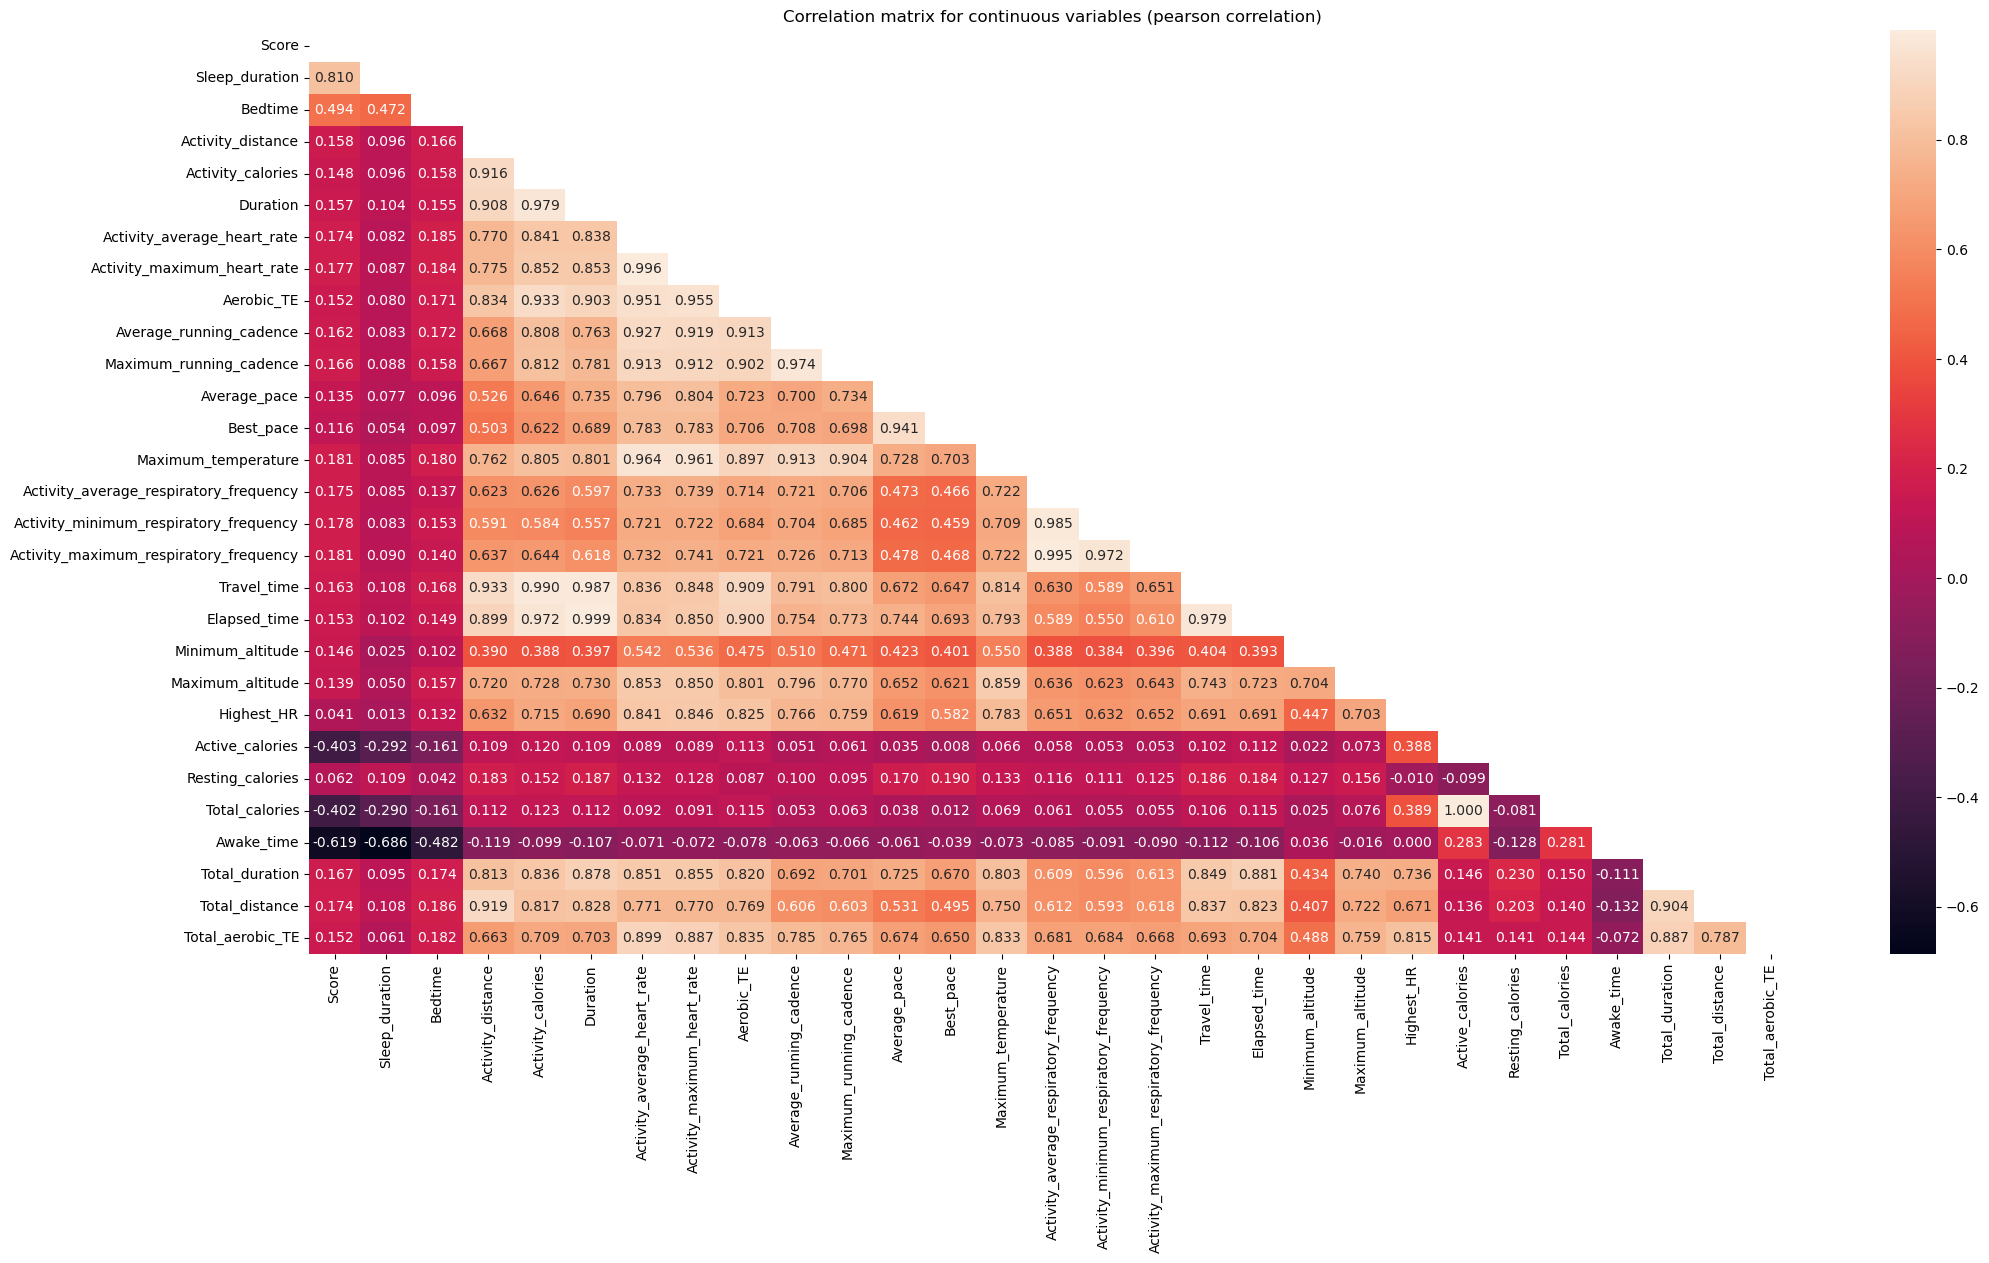

In [67]:
corr = df_merged[continuous_vars].drop(columns=['Date']).corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(24, 12))
sns.heatmap(corr, mask=mask, annot=True, fmt='.3f')
plt.title('Correlation matrix for continuous variables (pearson correlation)')
plt.show()

### Model with feature selection results
<hr>
From now on, our working dataset will be df_work, which contains the columns of both feature selection methods.

In [68]:
# Sets our working dataframe with our previously selected columns 
df_work = df_merged[['Score'] + list(feat_select_vars)]

work_cat_vars = ['Type', 'N_activities']
work_num_vars = [col for col in df_work.columns if col not in work_cat_vars]

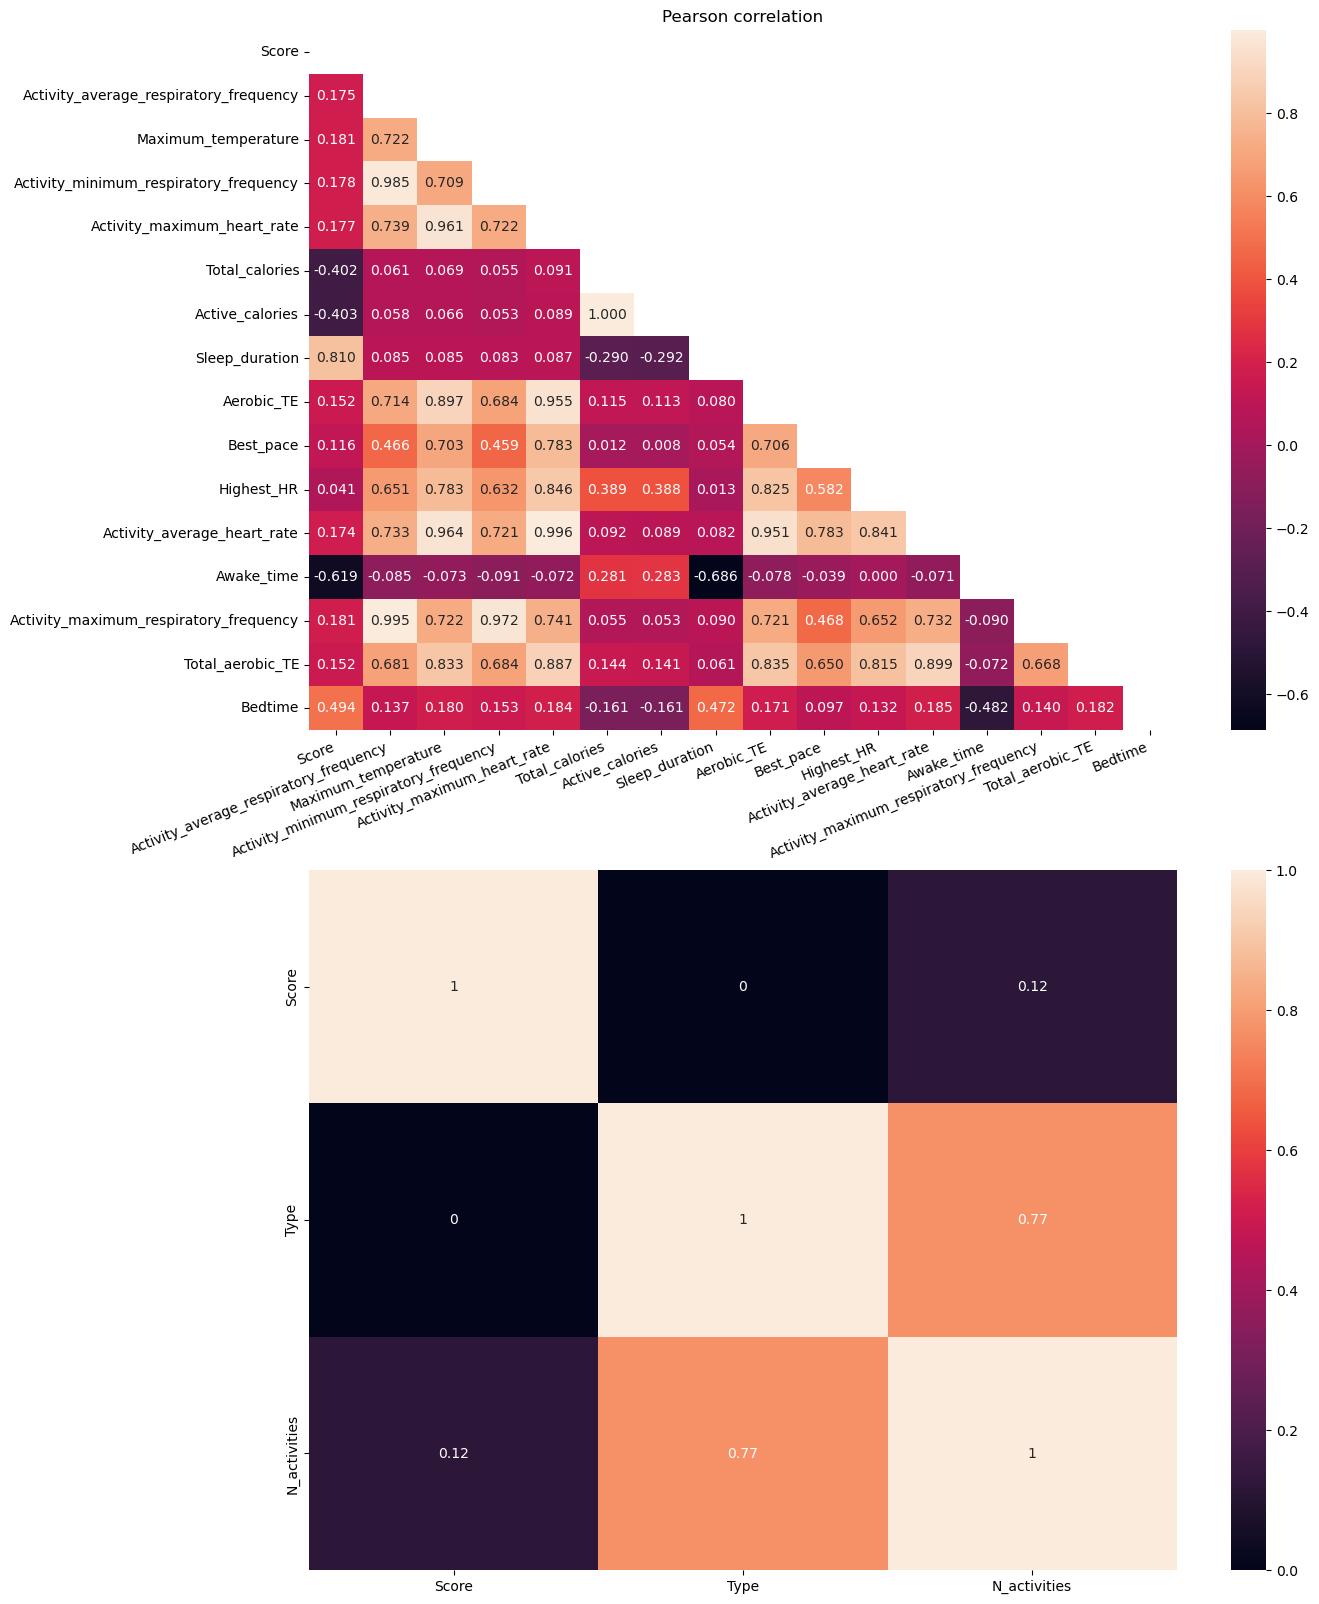

<Figure size 1400x600 with 0 Axes>

In [69]:
fig, axs = plt.subplots(2, 1, figsize=(14, 20))

# Generate a diagonal correlation matrix
corr = df_work[work_num_vars].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14, 6))
sns.heatmap(corr, mask=mask, annot=True, fmt='.3f', ax=axs[0])
axs[0].set_title('Pearson correlation')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=22, ha='right')

# To work on
sns.heatmap(cramers_matrix(df_work[['Score'] + work_cat_vars]), annot=True, ax=axs[1])
axs[1].set_title('')

plt.tight_layout()
plt.show()

In [70]:
lr_work = LinearRegression()
X = df_work[[col for col in df_work.columns if 'Score' not in col]]
y = df_work['Score']

random_state = 42
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

work_cv_resuls = cross_validate(
    estimator=lr_work,
    X=X,
    y=y,
    cv=skf,
    scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'),
    return_train_score=True
)

work_train_rmse_full = work_cv_resuls['train_neg_mean_squared_error']
work_test_rmse_full = work_cv_resuls['test_neg_mean_squared_error']

work_train_rmse = np.sqrt(np.abs(work_train_rmse_full)).mean()
work_test_rmse = np.sqrt(np.abs(work_test_rmse_full)).mean()

print(f"Work train RMSE : {work_train_rmse:.3f} | Base train RMSE : {base_train_rmse:.3f} | Diff : {work_train_rmse - base_train_rmse:.3f} | stddev : {np.std(work_train_rmse_full):.3f}")
print(f"Work test RMSE : {work_test_rmse:.3f} | Base test RMSE : {base_test_rmse:.3f} | Diff : {work_test_rmse - base_test_rmse:.3f} | stddev : {np.std(work_test_rmse_full):.3f}")

Work train RMSE : 11.119 | Base train RMSE : 10.881 | Diff : 0.238 | stddev : 5.870
Work test RMSE : 11.748 | Base test RMSE : 12.007 | Diff : -0.259 | stddev : 16.542


# 3.Exploratory Data Analysis <a id='eda'></a>
<a href="#table_contents">Table of contents</a>

In [71]:
df_work.columns

Index(['Score', 'Activity_average_respiratory_frequency',
       'Maximum_temperature', 'Activity_minimum_respiratory_frequency',
       'Activity_maximum_heart_rate', 'Total_calories', 'Active_calories',
       'Sleep_duration', 'Aerobic_TE', 'Best_pace', 'Highest_HR',
       'Activity_average_heart_rate', 'Awake_time',
       'Activity_maximum_respiratory_frequency', 'Total_aerobic_TE',
       'N_activities', 'Bedtime', 'Type'],
      dtype='object')

## Score

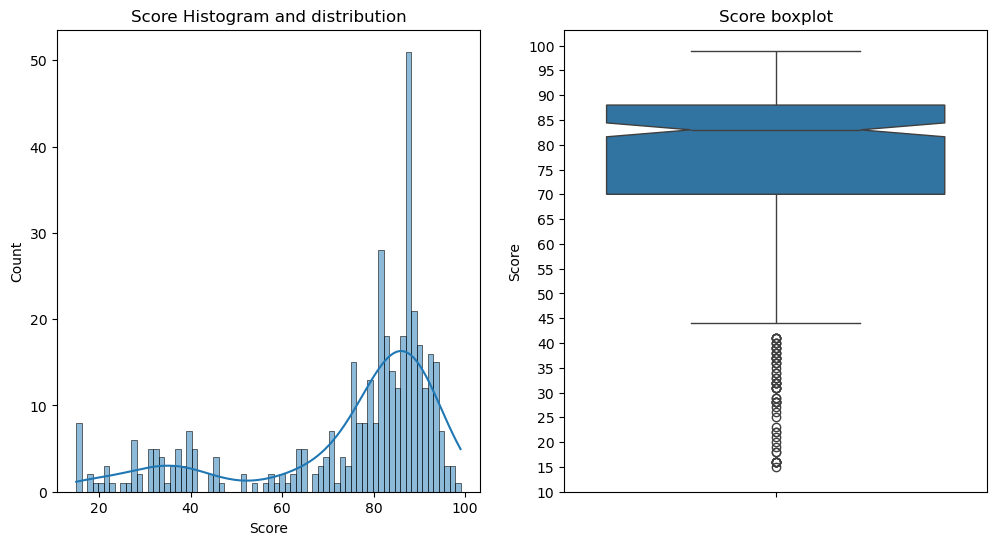

In [72]:
bins = df_work['Score'].nunique()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=df_work, x='Score', kde=True, bins=bins, ax=axs[0])
axs[0].set_title('Score Histogram and distribution')

sns.boxplot(data=df_work, y='Score', ax=axs[1], notch=True)
axs[1].set_title('Score boxplot')
axs[1].set_yticks([i for i in range(10, 100+5, 5)])

plt.show()

## Best_pace

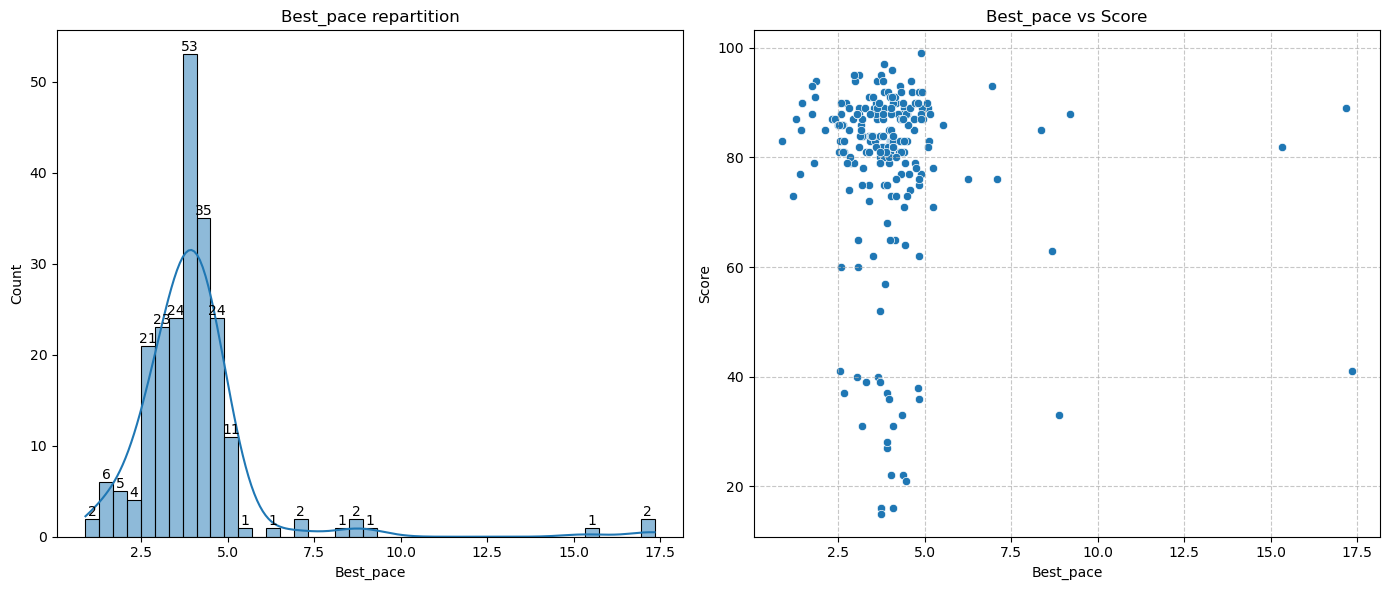

In [73]:
univariate_continous_EDA(data=df_work, var='Best_pace', target='Score', activity_related=True)

## Activity maximum and average heart rate, Highest HR

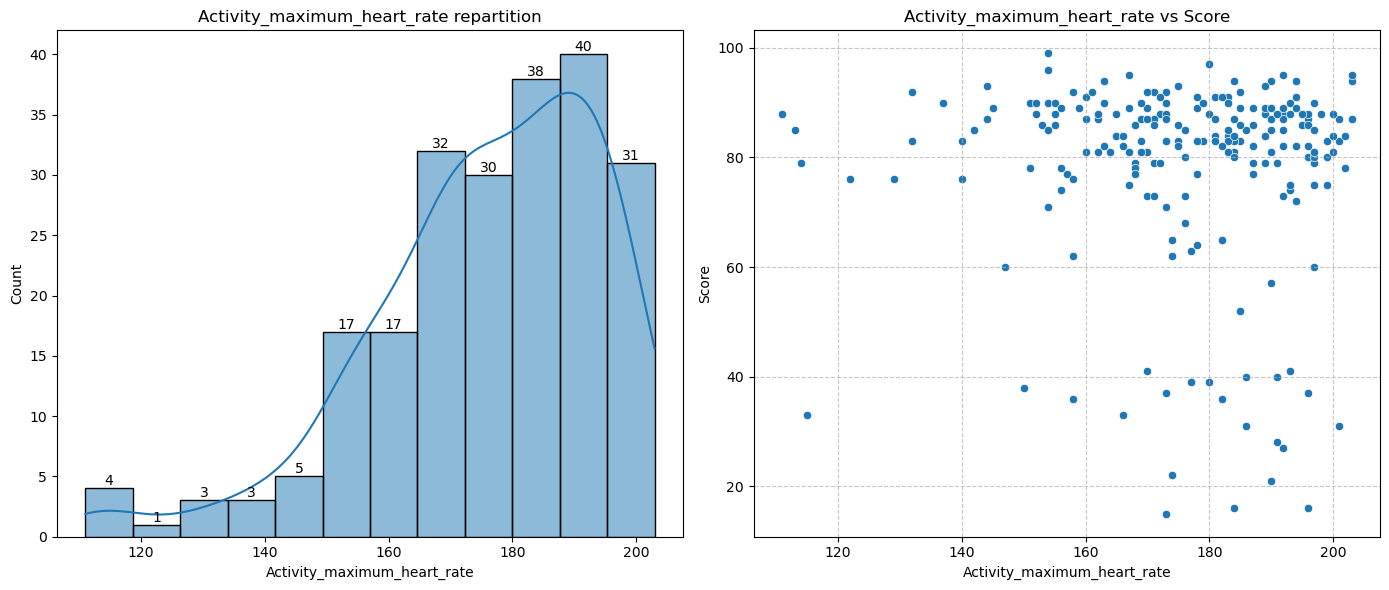

In [74]:
univariate_continous_EDA(data=df_work, var='Activity_maximum_heart_rate', target='Score', activity_related=True)

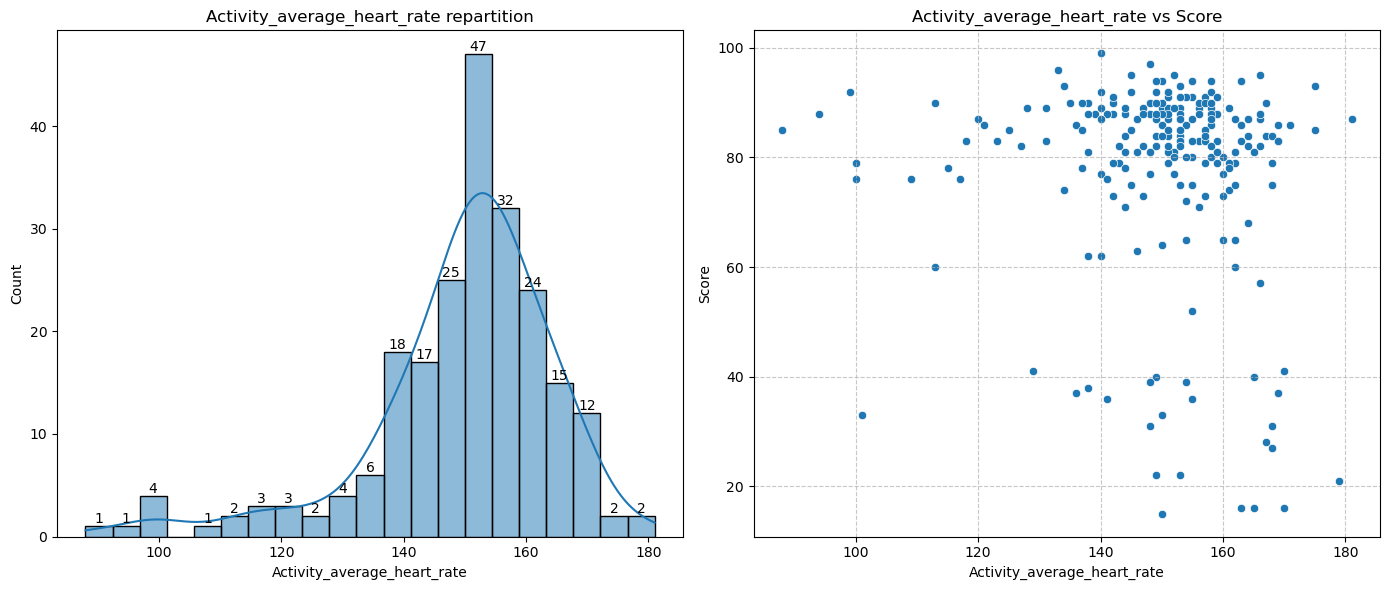

In [75]:
univariate_continous_EDA(data=df_work, var='Activity_average_heart_rate', target='Score', activity_related=True)

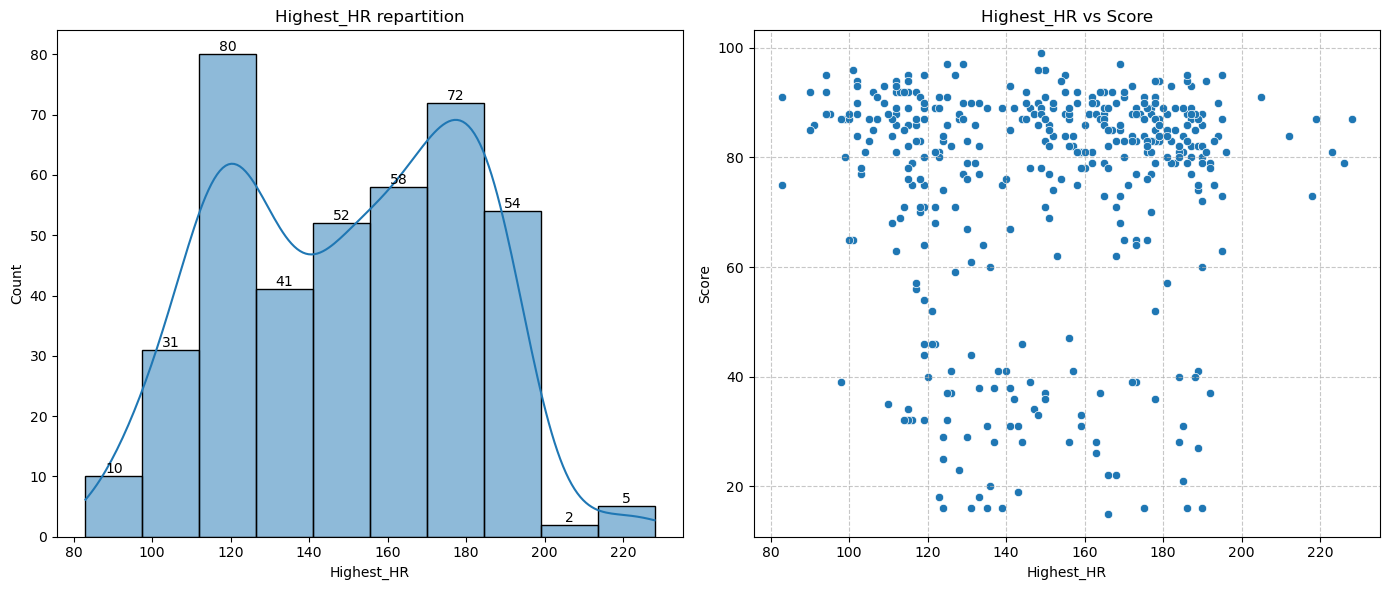

In [76]:
univariate_continous_EDA(data=df_work, var='Highest_HR', target='Score', activity_related=True)

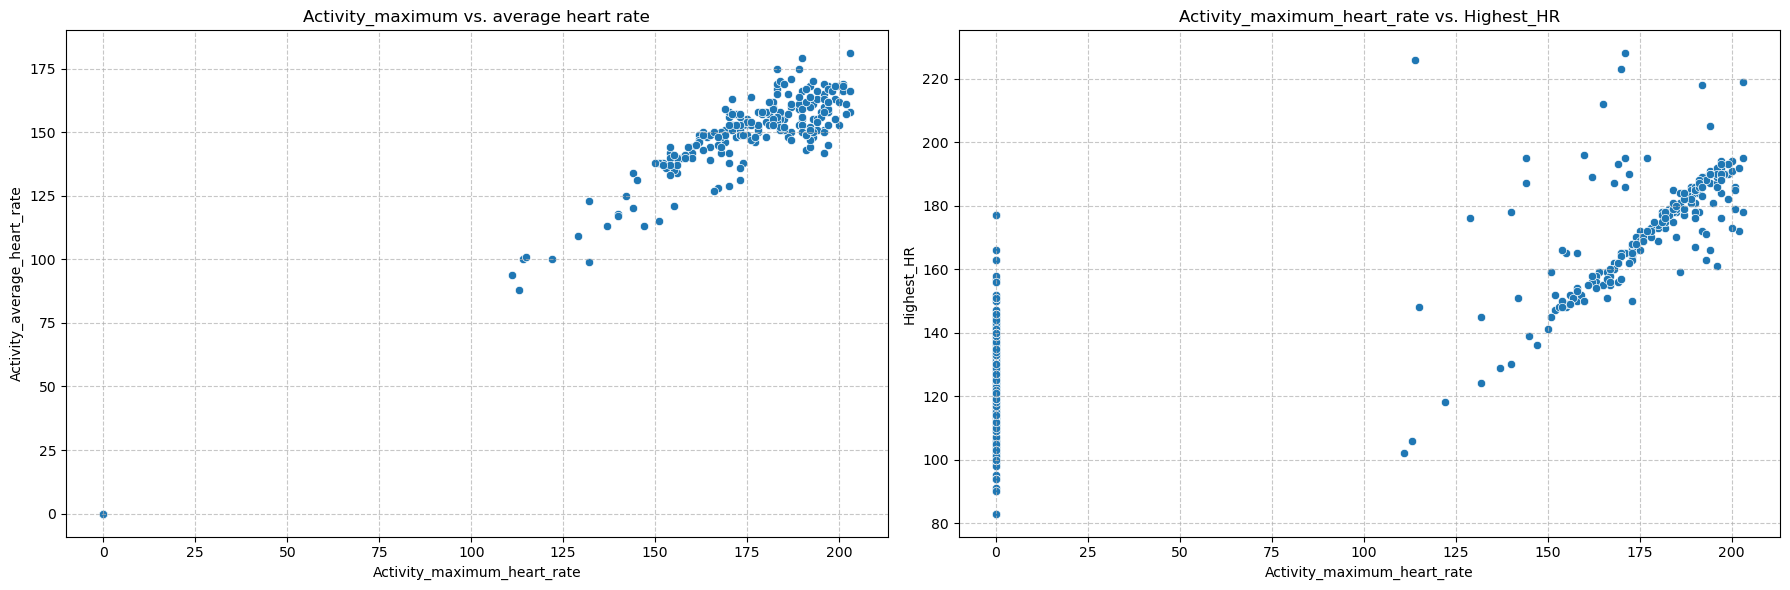

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # 2 rows, 1 column


sns.scatterplot(data=df_work, x='Activity_maximum_heart_rate', y='Activity_average_heart_rate', ax=axs[0])

axs[0].set_xlabel('Activity_maximum_heart_rate')
axs[0].set_ylabel('Activity_average_heart_rate')
axs[0].set_title('Activity_maximum vs. average heart rate')

axs[0].grid(True, linestyle='--', alpha=0.7)


sns.scatterplot(data=df_work, x='Activity_maximum_heart_rate', y='Highest_HR', ax=axs[1])

axs[1].set_xlabel('Activity_maximum_heart_rate')
axs[1].set_ylabel('Highest_HR')
axs[1].set_title('Activity_maximum_heart_rate vs. Highest_HR')

axs[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

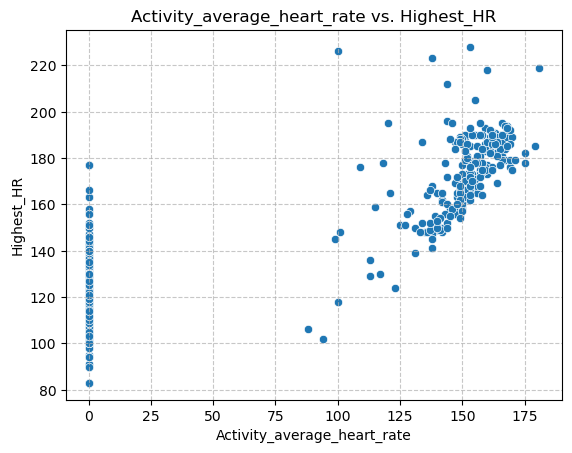

In [78]:
continuous_bivariate_scatter(data=df_work, var_1='Activity_average_heart_rate', var_2='Highest_HR')

## Type and N_activities

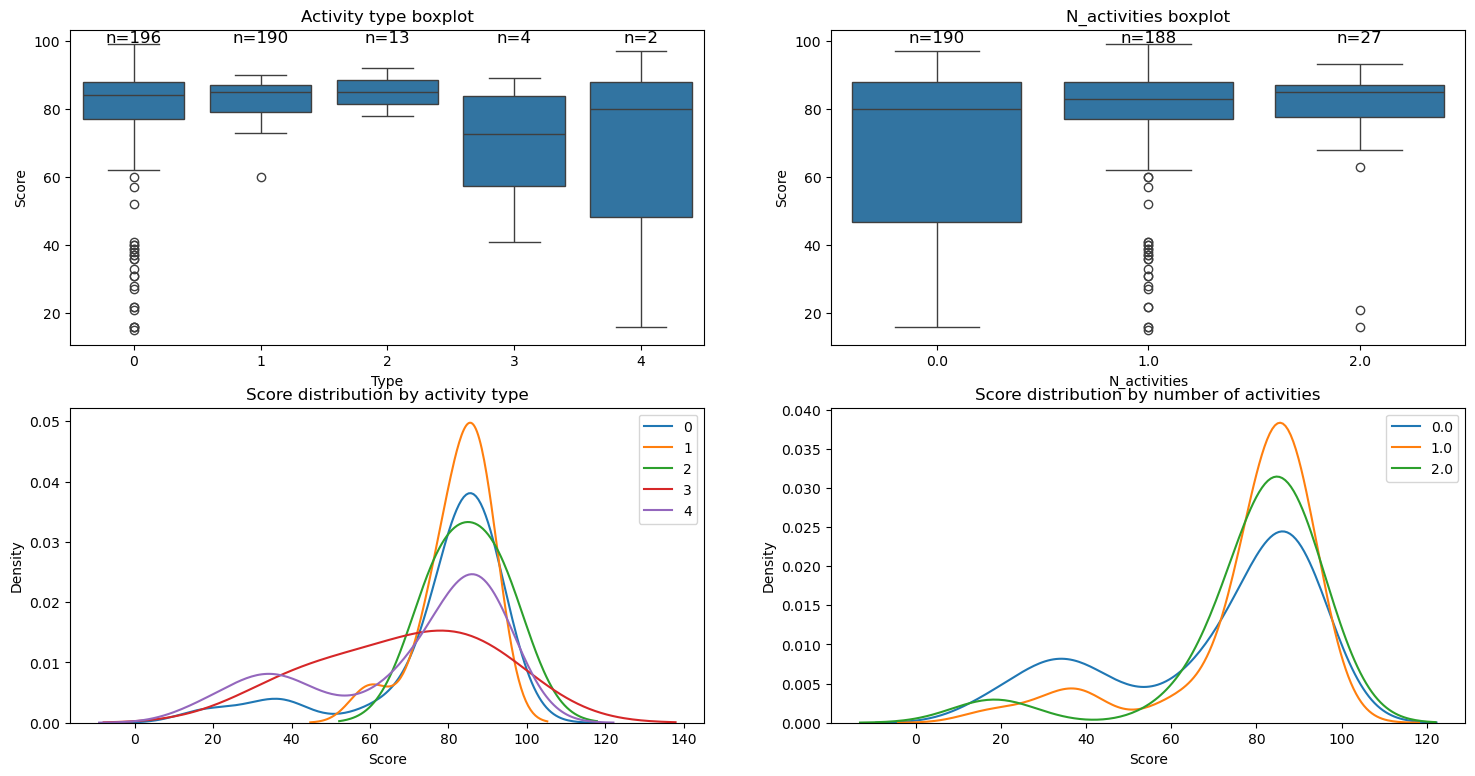

In [79]:
fig, axs = plt.subplots(2, 2, figsize=(18, 9))

# Type boxplot
sns.boxplot(data=df_work, x='Type', y='Score', ax=axs[0, 0])
axs[0,0].set_title('Activity type boxplot')

group_sizes = df_work['Type'].value_counts()

for i, group in enumerate(group_sizes.index):
    size = group_sizes[group]# Positioning above the boxplot
    axs[0, 0].text(i, 103, f'n={size}', ha='center', va='top', fontsize=12, color='black')

# Type kdeplot
for i in sorted(df_work['Type'].unique()):
    sns.kdeplot(data=df_work.loc[df_work['Type'] == i], x='Score', label=i, ax=axs[1, 0])
axs[1, 0].legend()
axs[1, 0].set_title('Score distribution by activity type')



# N_activities boxplot
sns.boxplot(data=df_work, x='N_activities', y='Score', ax=axs[0, 1])
axs[0, 1].set_title('N_activities boxplot')

group_sizes = df_work['N_activities'].value_counts()

for i, group in enumerate(group_sizes.index):
    size = group_sizes[group]# Positioning above the boxplot
    axs[0, 1].text(i, 103, f'n={size}', ha='center', va='top', fontsize=12, color='black')

# N_activities kdeplot
for i in df_work['N_activities'].unique():
    sns.kdeplot(data=df_work.loc[df_work['N_activities'] == i], x='Score', label=i, ax=axs[1, 1])
axs[1, 1].legend()
axs[1, 1].set_title('Score distribution by number of activities')

plt.show()

## Bedtime, Awake_time and Sleep_duration

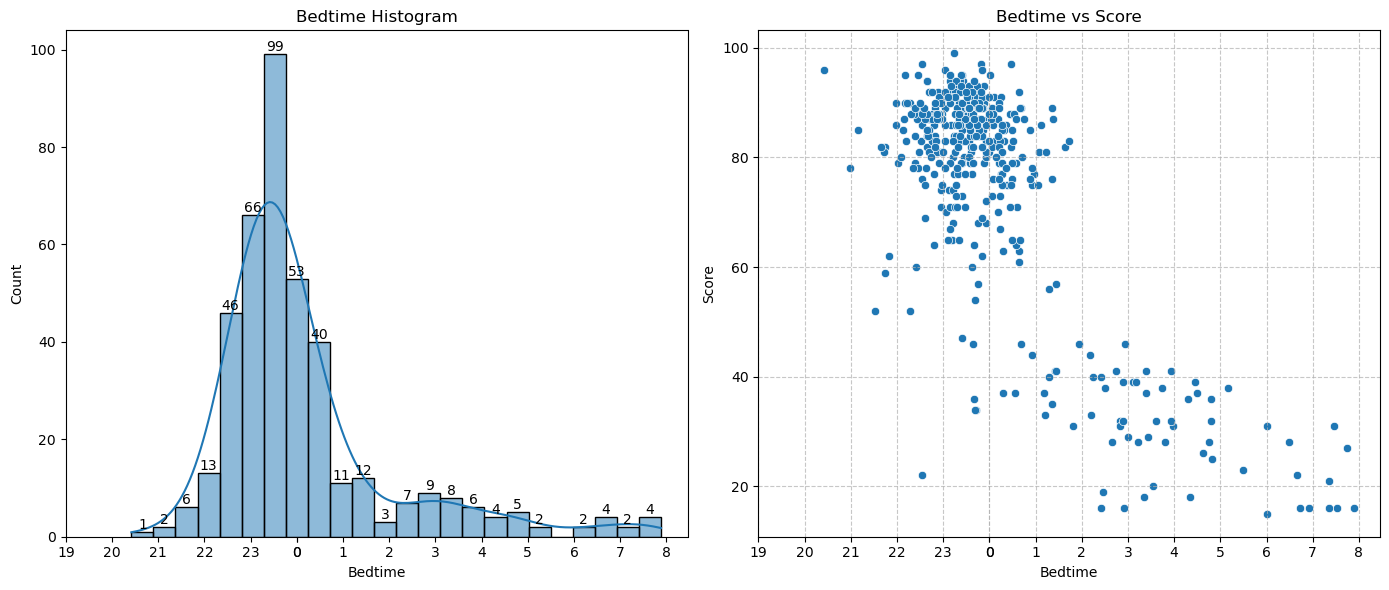

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

xticks = list(range(19, 25)) + list(range(0, 9))  # 18-24 followed by 0-8
xtick_labels = ['19', '20', '21', '22', '23', '24', '0', '1', '2', '3', '4', '5', '6', '7', '8']

# In order to have the bedtimes following on the graph we have to add 24 to them and play with the x label
adjusted_bedtime = df_work['Bedtime'].apply(lambda x: x + 24 if x < 8 else x)

# Histplot
bars = sns.histplot(adjusted_bedtime, bins=24, ax=axs[0], kde=True)
axs[0].set_title('Bedtime Histogram')
axs[0].set_xticks(ticks=list(range(19, 25)) + list(range(24, 33)), labels=xtick_labels)

# Scatterplot
sns.scatterplot(x=adjusted_bedtime, y=df_work['Score'], ax=axs[1])
axs[1].set_xticks(ticks=list(range(19, 25)) + list(range(24, 33)), labels=xtick_labels)
axs[1].set_xlabel("Bedtime")
axs[1].set_ylabel("Score")
axs[1].grid(visible=True, linestyle='--', alpha=0.7)
axs[1].set_title("Bedtime vs Score")

for bar in bars.patches:
    height = bar.get_height()
    bars.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'{int(height)}' if height else '',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

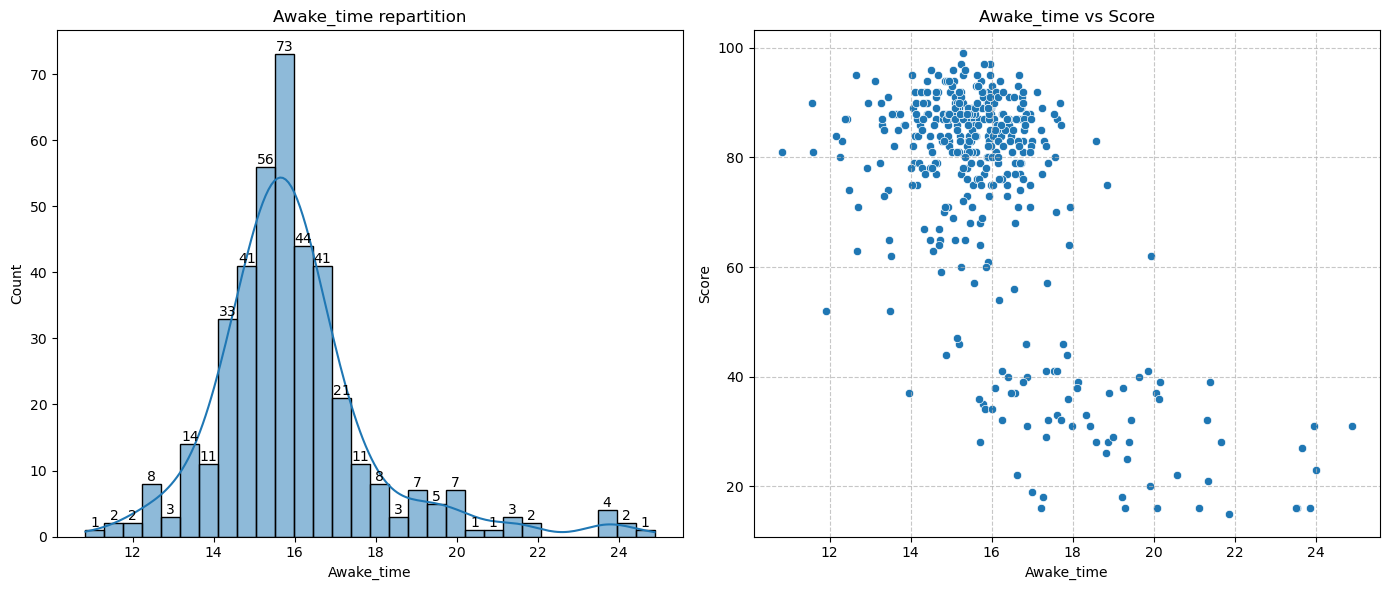

In [81]:
univariate_continous_EDA(data=df_work, var='Awake_time')

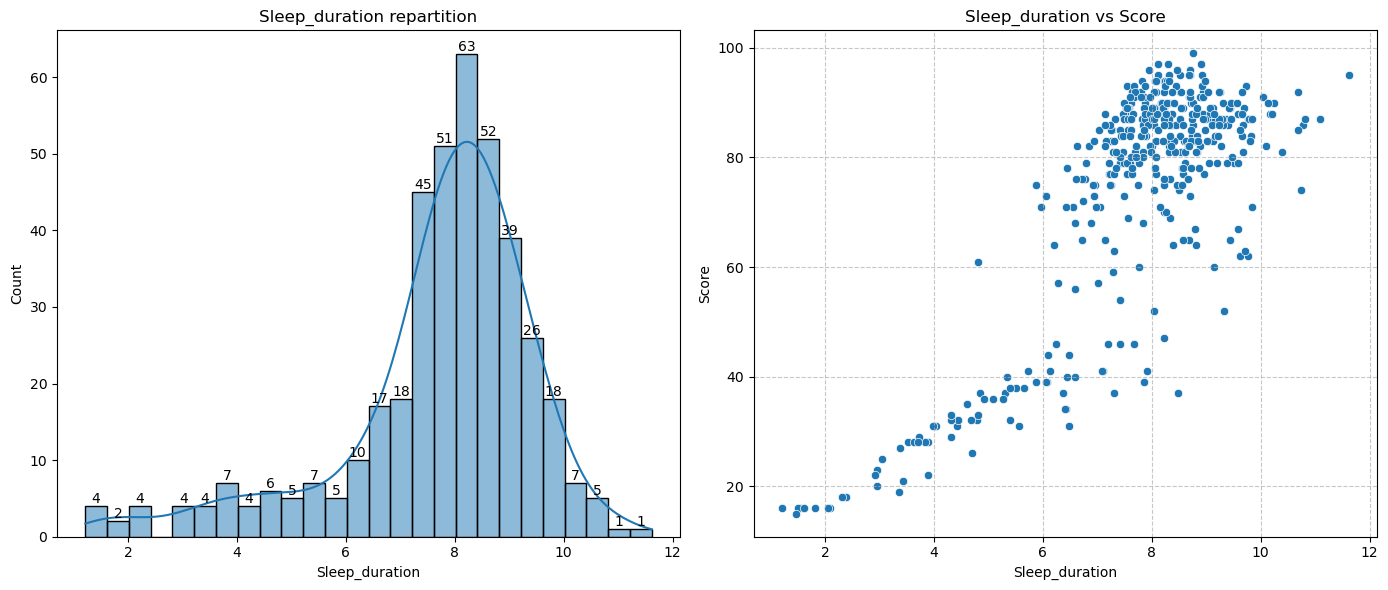

In [82]:
univariate_continous_EDA(data=df_work, var='Sleep_duration')

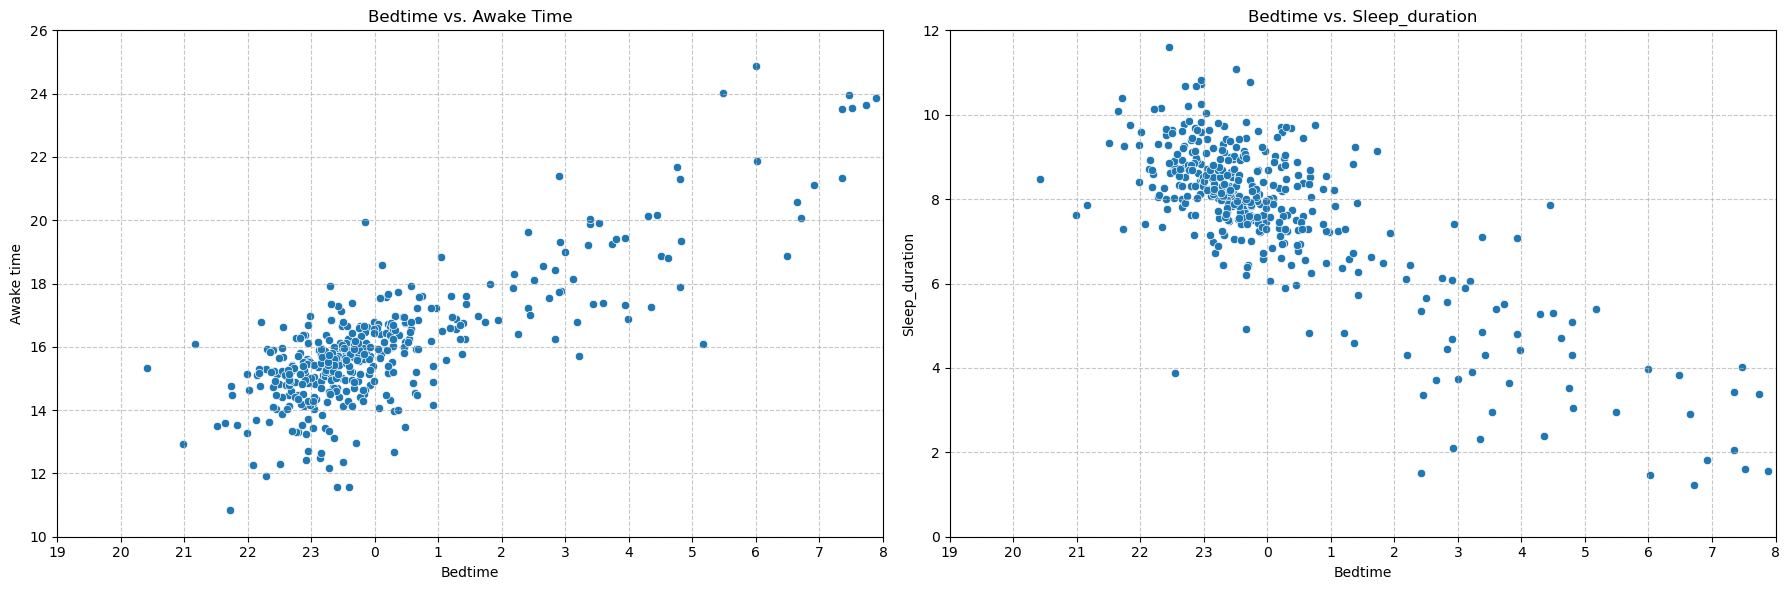

In [83]:
# Create a copy of the dataframe to avoid modifying the original
df_plot = df_work.copy()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # 2 rows, 1 column

# Adjust bedtime values: add 24 to times before 19:00
df_plot['Bedtime_adjusted'] = np.where(df_plot['Bedtime'] < 19, df_plot['Bedtime'] + 24, df_plot['Bedtime'])

sns.scatterplot(data=df_plot, x='Bedtime_adjusted', y='Awake_time', ax=axs[0])

axs[0].set_xlim(19, 32)  # Set x-axis limits from 19 to 32 (8 AM next day)
axs[0].set_ylim(10, 26)  # Adjust y-axis limits as needed

# Set custom tick locations and labels
tick_locations = np.arange(19, 33)
tick_labels = [str(i % 24) for i in range(19, 33)]
axs[0].set_xticks(tick_locations)
axs[0].set_xticklabels(tick_labels)

axs[0].set_xlabel('Bedtime')
axs[0].set_ylabel('Awake time')
axs[0].set_title('Bedtime vs. Awake Time')

axs[0].grid(True, linestyle='--', alpha=0.7)

# Plot on axs[1]
sns.scatterplot(data=df_plot, x='Bedtime_adjusted', y='Sleep_duration', ax=axs[1])

axs[1].set_xlim(19, 32)  # Set x-axis limits from 19 to 32 (8 AM next day)
axs[1].set_ylim(0, 12)  # Adjust y-axis limits as needed

# Set custom tick locations and labels
tick_locations = np.arange(19, 33)
tick_labels = [str(i % 24) for i in range(19, 33)]
axs[1].set_xticks(tick_locations)
axs[1].set_xticklabels(tick_labels)

axs[1].set_xlabel('Bedtime')
axs[1].set_ylabel('Sleep_duration')
axs[1].set_title('Bedtime vs. Sleep_duration')

axs[1].grid(True, linestyle='--', alpha=0.7)

# If this is the last plot, you might want to adjust the layout and show the figure
plt.tight_layout()
plt.show()

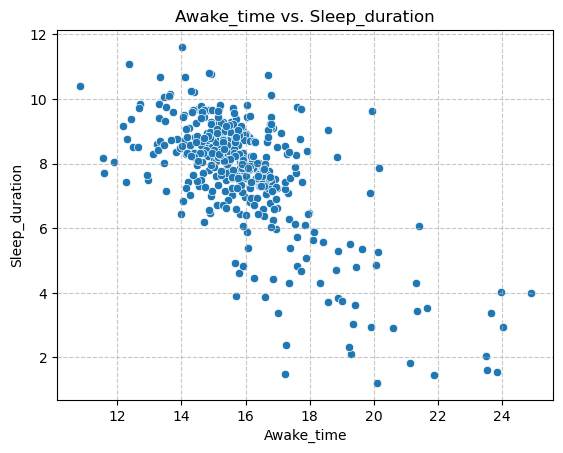

In [84]:
continuous_bivariate_scatter(data=df_work, var_1='Awake_time', var_2='Sleep_duration')

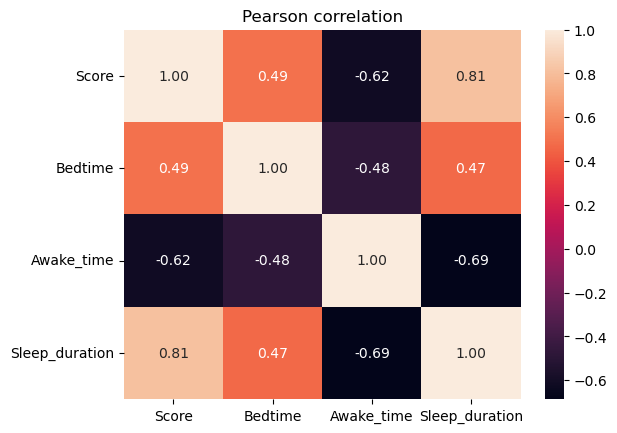

In [85]:
sns.heatmap(df_work[['Score', 'Bedtime', 'Awake_time', 'Sleep_duration']].corr(method='pearson'), annot=True, fmt=".2f")

plt.title("Pearson correlation")
plt.show()

In [86]:
# df_work['Awake_sleep_ratio'] = df_work['Awake_time'] / df_work['Sleep_duration']
# sns.heatmap(df_work[['Score', 'Bedtime', 'Awake_time', 'Sleep_duration', 'Awake_sleep_ratio']].corr(method='pearson'), annot=True, fmt=".2f")

## Activity maximum, minimum and average, respiratory frequency

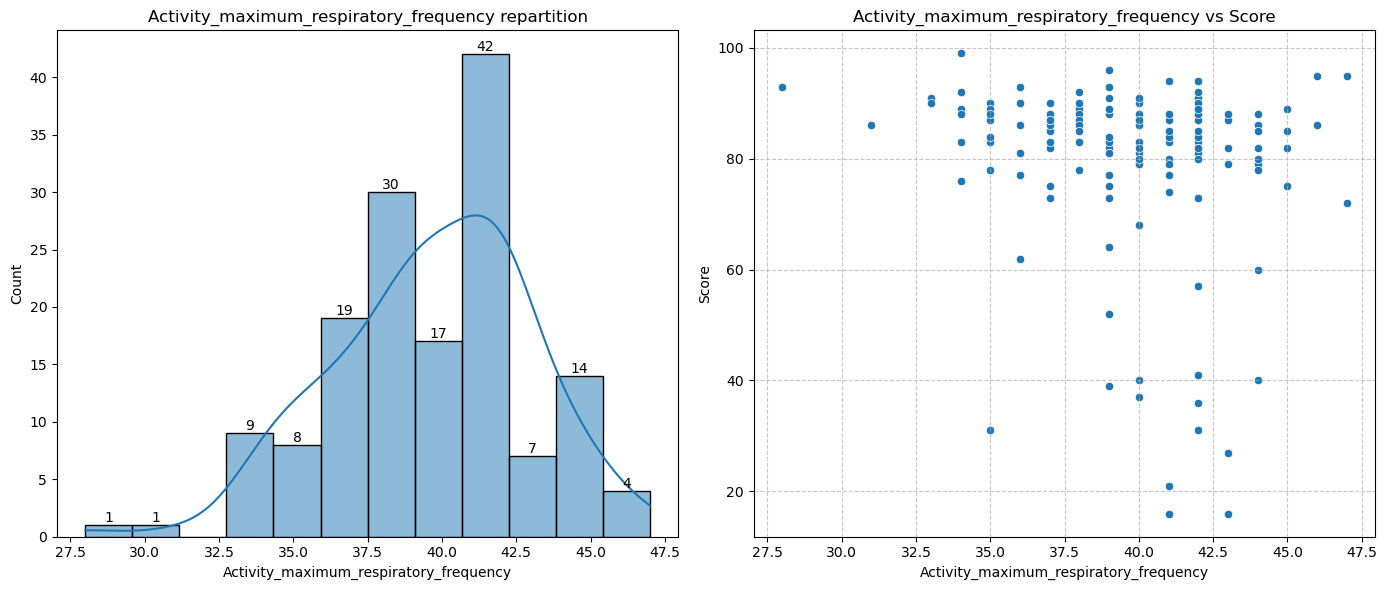

In [87]:
univariate_continous_EDA(data=df_work, var='Activity_maximum_respiratory_frequency', activity_related=True)

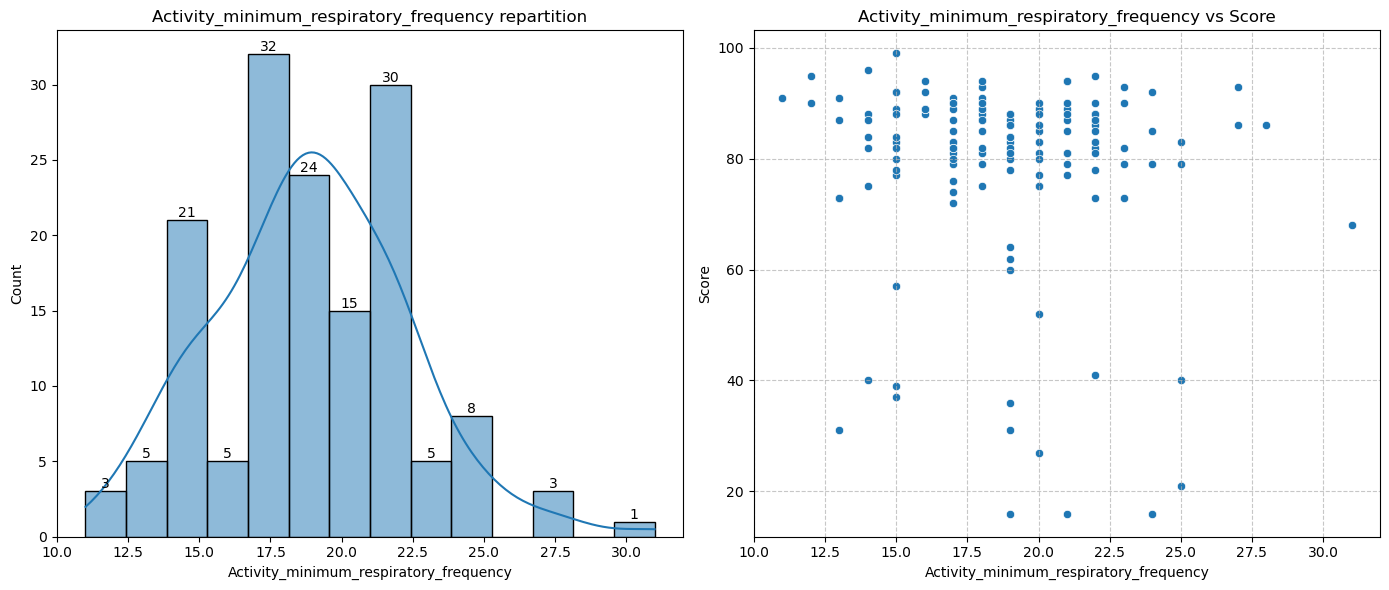

In [88]:
univariate_continous_EDA(data=df_work, var='Activity_minimum_respiratory_frequency', activity_related=True)

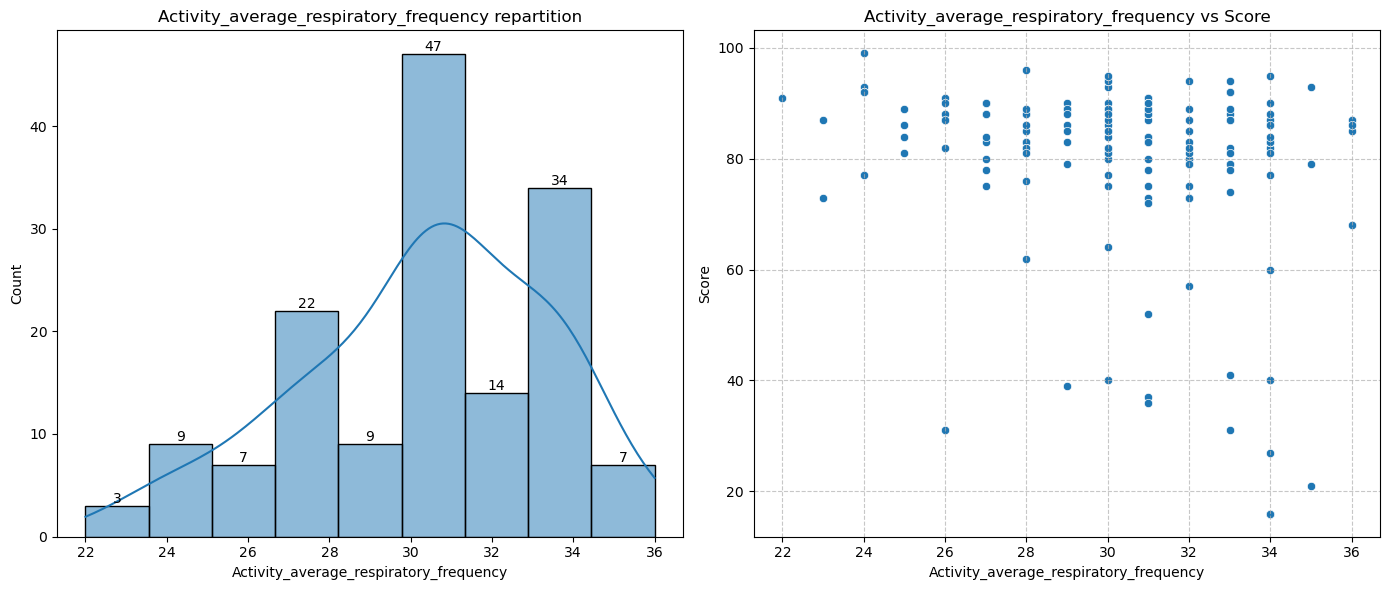

In [89]:
univariate_continous_EDA(data=df_work, var='Activity_average_respiratory_frequency', activity_related=True)

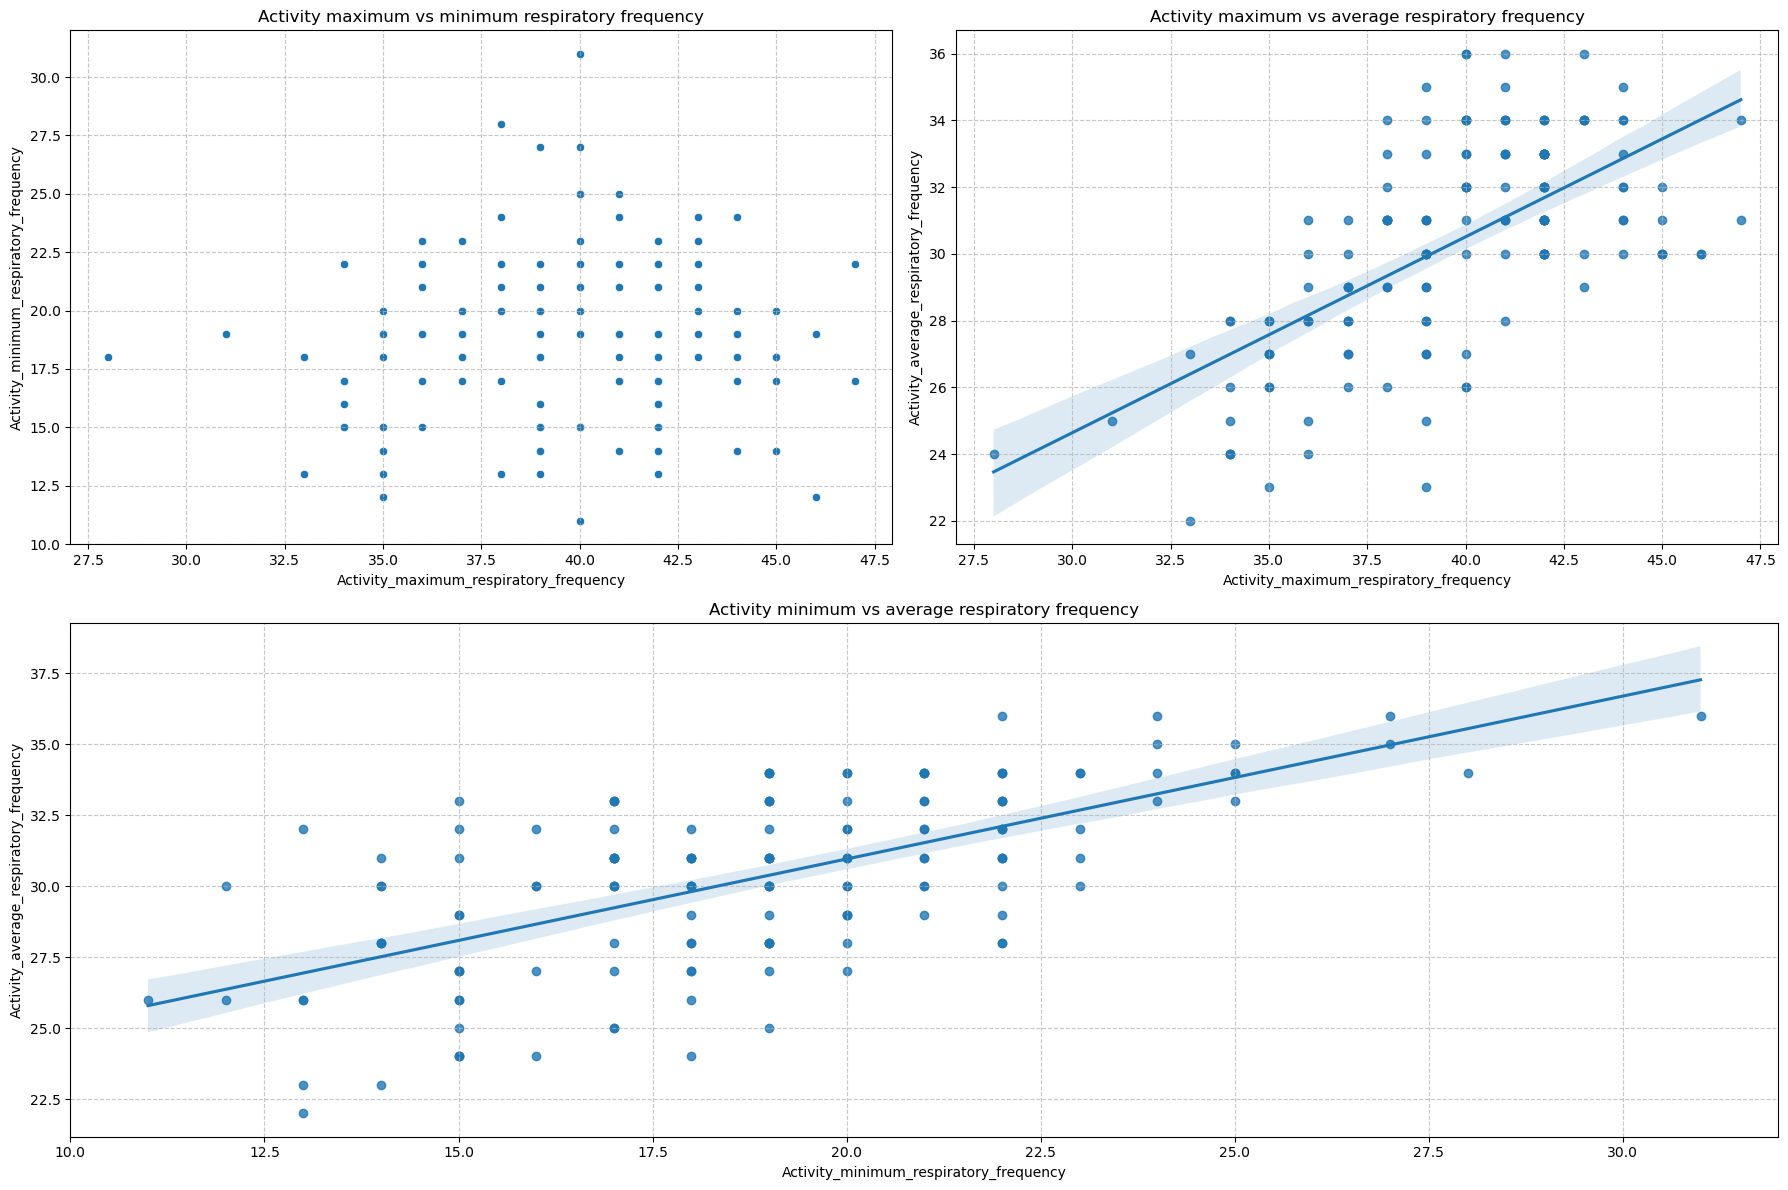

In [90]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

sns.scatterplot(data=df_work.loc[df_work['Activity_maximum_respiratory_frequency'] != 0],
                x='Activity_maximum_respiratory_frequency',
                y='Activity_minimum_respiratory_frequency',
                ax=axs[0, 0])

axs[0, 0].set_title('Activity maximum vs minimum respiratory frequency')
axs[0, 0].grid(True, linestyle='--', alpha=0.7)


sns.regplot(data=df_work.loc[df_work['Activity_maximum_respiratory_frequency'] != 0],
                x='Activity_maximum_respiratory_frequency',
                y='Activity_average_respiratory_frequency',
                ax=axs[0, 1])

axs[0, 1].set_title('Activity maximum vs average respiratory frequency')
axs[0, 1].grid(True, linestyle='--', alpha=0.7)

fig.delaxes(axs[1, 1])
axs[1, 0].remove()
ax_big = fig.add_subplot(2, 1, 2)  # Add a new subplot that spans the entire second row


sns.regplot(data=df_work.loc[df_work['Activity_minimum_respiratory_frequency'] != 0],
                x='Activity_minimum_respiratory_frequency',
                y='Activity_average_respiratory_frequency',
                ax=ax_big)

ax_big.set_title('Activity minimum vs average respiratory frequency')
ax_big.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Total and Active Calories

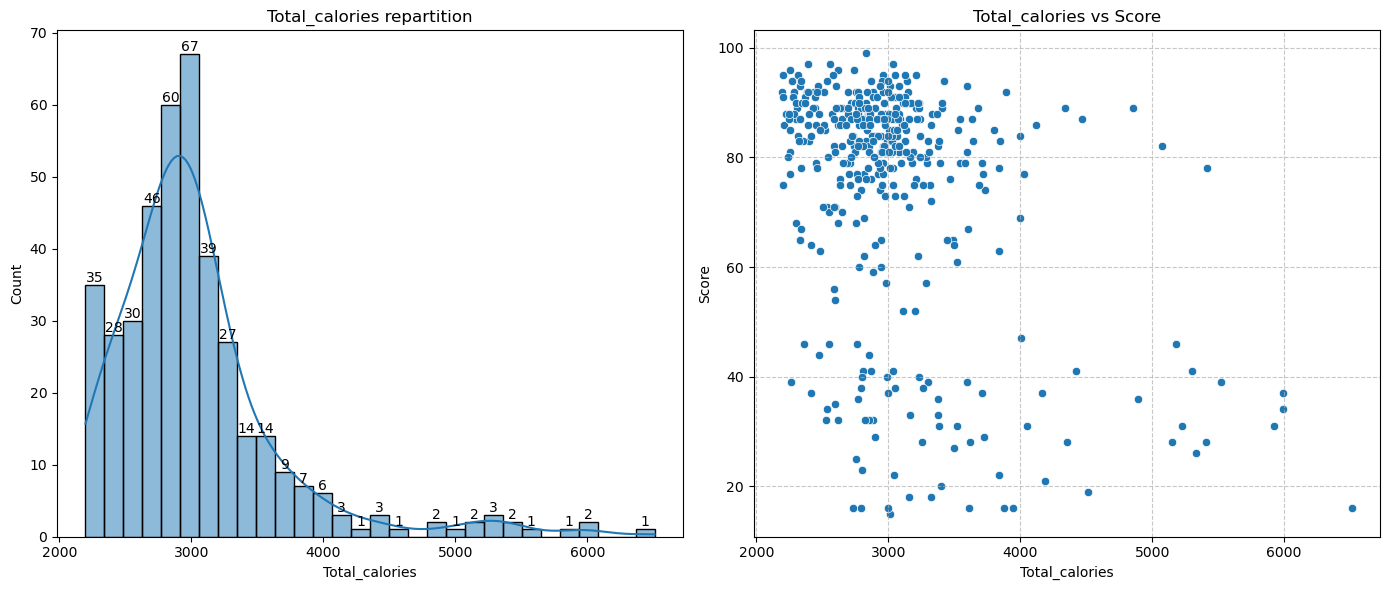

In [91]:
univariate_continous_EDA(data=df_work, var='Total_calories')

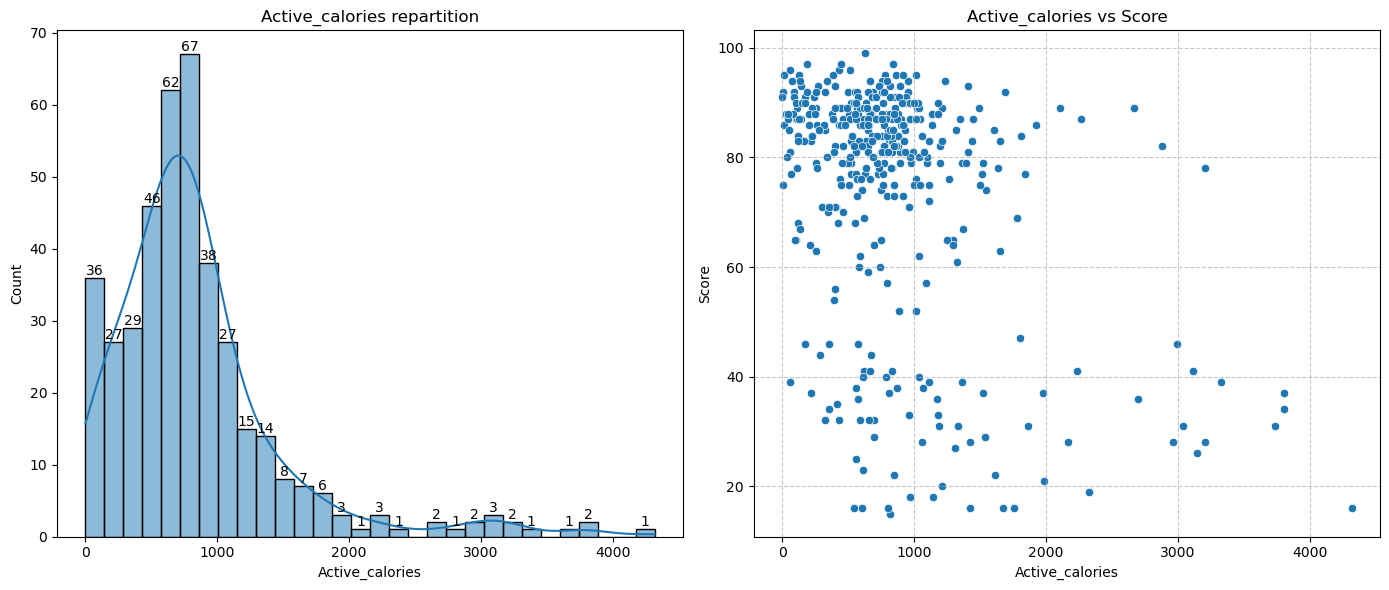

In [92]:
univariate_continous_EDA(data=df_work, var='Active_calories')

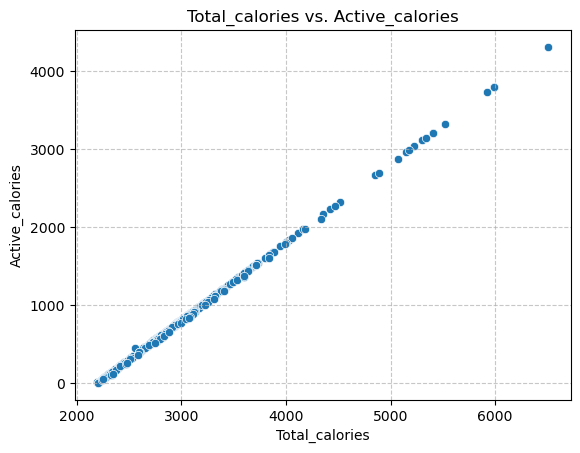

In [93]:
continuous_bivariate_scatter(data=df_work, var_1='Total_calories', var_2='Active_calories')

## Total aerobic TE

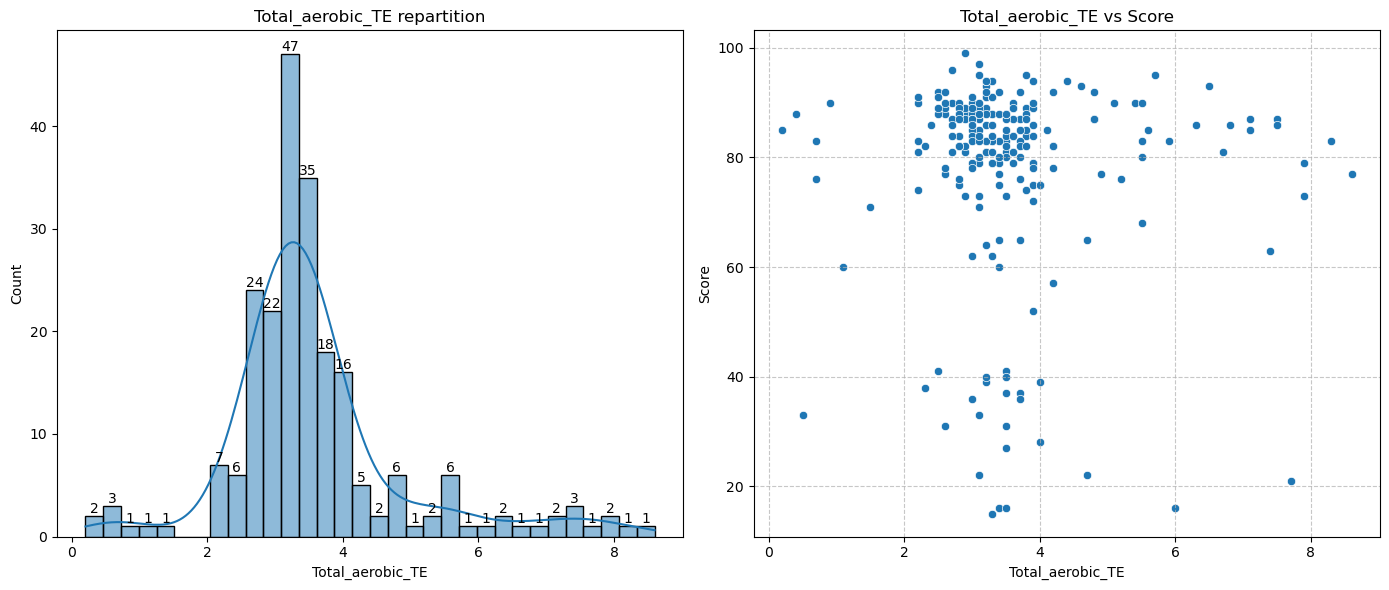

In [94]:
univariate_continous_EDA(data=df_work, var='Total_aerobic_TE', activity_related=True)

## Maximum temperature

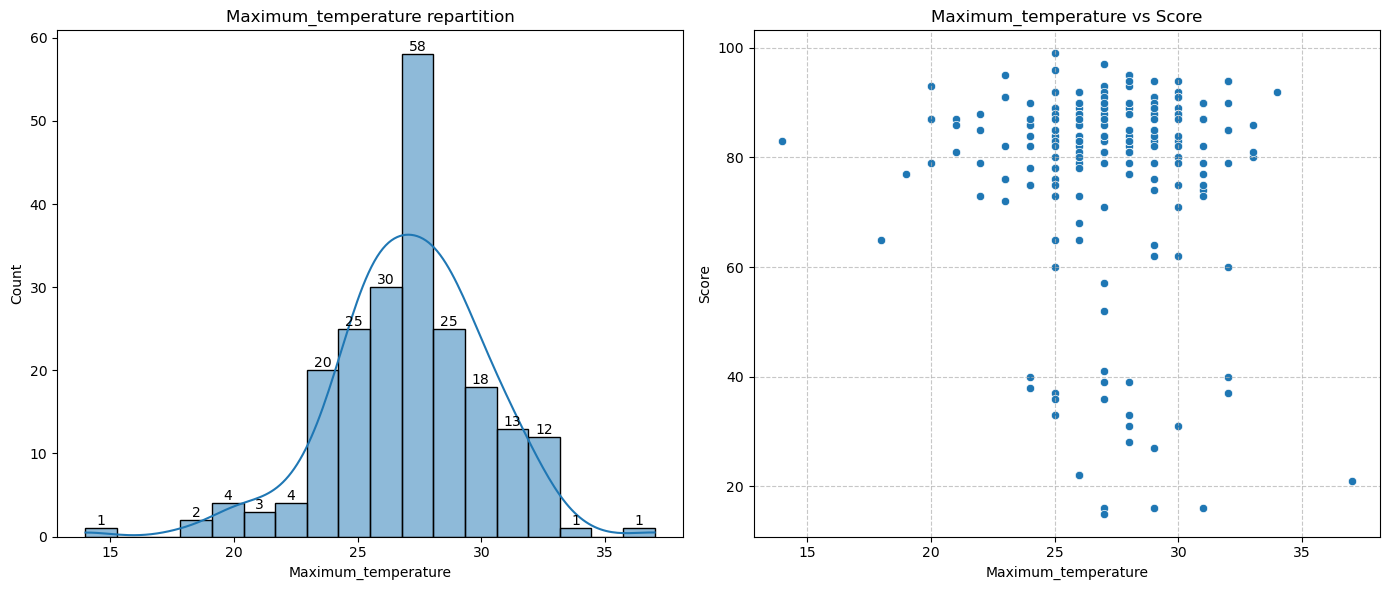

In [95]:
univariate_continous_EDA(data=df_work, var='Maximum_temperature', activity_related=True)

# 4.Training Models

In [96]:
X = df_work[[col for col in df_work.columns if 'Score' not in col and "Quality" not in col]]
Y = df_work['Score']

In [97]:
random_state = 42
test_size = 0.4

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

## Linear Model

In [99]:
work_lr, work_lr_perf_dict = lin_reg_train_test(X=X, y=y, test_size=test_size,
                                                random_state=random_state,
                                                mlflow_register=False)

for key, val in work_lr_perf_dict.items():
    print(f"{key} : {val:.3f}")

lr_rmse_train : 11.275
lr_mae_train : 9.062
lr_r2_train : 0.695
lr_adjusted_r2_train : 0.672
lr_rmse_test : 11.687
lr_mae_test : 9.343
lr_r2_test : 0.736
lr_adjusted_r2_test : 0.705


## Random Forest

In [100]:
rf_params = {'max_depth': 3}
rf_run_name = "Random forest raw features from feature selection (K-Fold score)"

rf_rmse_train : 8.138
rf_mae_train : 5.957
rf_r2_train : 0.841
rf_adjusted_r2_train : 0.829
rf_rmse_test : 10.053
rf_mae_test : 7.269
rf_r2_test : 0.805
rf_adjusted_r2_test : 0.782


In [113]:
scoring = ('neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2')

In [114]:
random_forest_cross_val_perf = random_forest_cross_val(X=X, y=y,
                                                       rf_params=rf_params, random_state=random_state,
                                                       stratified_k_fold=True, n_splits=4, 
                                                       scoring=scoring, return_train_score=True)

In [115]:
random_forest_cross_val_perf

{'fit_time': array([0.16499996, 0.16600156, 0.16604233, 0.16003275]),
 'score_time': array([0.00700092, 0.00596738, 0.00598979, 0.00596666]),
 'test_neg_root_mean_squared_error': array([-11.17623286,  -9.17001896,  -7.99771765, -11.6934923 ]),
 'train_neg_root_mean_squared_error': array([-8.17697082, -8.66465297, -8.85745385, -7.84667632]),
 'test_neg_mean_absolute_error': array([-7.73706146, -6.12802396, -6.58321368, -8.10653666]),
 'train_neg_mean_absolute_error': array([-5.8852461 , -6.30352637, -6.21302595, -5.55632504]),
 'test_r2': array([0.79598113, 0.83469507, 0.80328332, 0.53876817]),
 'train_r2': array([0.82509067, 0.83008988, 0.8400366 , 0.87914914])}

## Gradient Boosting

In [104]:
# gboost_cv_parameters = {
#     'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05],
#     'n_estimators': [100, 200, 300, 400, 500, 600, 700],
#     'max_depth': [1, 2, 3, 4, 5],
#     'min_samples_leaf': [1, 2, 3, 5, 8],
#     'random_state': [random_state]
# }

# # Grid Search cross validation
# gboost_cv = GradientBoostingRegressor(random_state=random_state)
# clf_gboost = GridSearchCV(
#     estimator = gboost_cv, 
#     param_grid = gboost_cv_parameters, 
#     scoring='neg_mean_squared_error',
#     n_jobs = -2,
#     cv = 5,
#     return_train_score=True
# )

# clf_gboost.fit(X=X_train, y=y_train.ravel())

# gboost_gs = pd.DataFrame(clf_gboost.cv_results_)

# gboost_best_params = clf_gboost.best_params_
# gboost_best_params

In [105]:
gboost_best_params = {'learning_rate': 0.05,
                      'max_depth': 2,
                      'min_samples_leaf': 2,
                      'n_estimators': 100,
                      'random_state': 42}

gboost_best_params['verbose'] = False

In [124]:
run_name = 'Gradient Boosting raw features from feature selection'

work_gboost, work_gboost_perf_dict = gradient_boosting_train_test(X=X, y=y, test_size=test_size,
                                                                  gboost_params=gboost_best_params,
                                                                  mlflow_register=False, run_name=run_name,
                                                                  register_dataset=True)

for key, val in work_gboost_perf_dict.items():
    print(f"{key} : {val:.3f}")

gboost_rmse_train : 7.128
gboost_mae_train : 5.375
gboost_r2_train : 0.878
gboost_adjusted_r2_train : 0.869
gboost_rmse_test : 9.721
gboost_mae_test : 6.987
gboost_r2_test : 0.817
gboost_adjusted_r2_test : 0.796


In [125]:
gradient_boosting_cross_val_perf = gradient_boosting_cross_val(X=X, y=y, 
                                                               gboost_params=gboost_best_params, random_state=random_state,
                                                               stratified_k_fold=True, n_splits=3, scoring=scoring, return_train_score=True)

## XGBoost

In [108]:
# xgb_cv_parameters = {
#     'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05],
#     'n_estimators': [100, 200, 300, 400, 500, 600, 700],
#     'max_depth': [1, 2, 3, 4, 5, 6, 8, 10],
# }

# # Grid Search Cross Validation
# xgb_cv = XGBRegressor(seed=random_state)
# clf_xgb = GridSearchCV(
#     estimator = xgb_cv, 
#     param_grid = xgb_cv_parameters, 
#     scoring='neg_mean_squared_error',
#     n_jobs = -2,
#     cv = 5,
#     return_train_score=True
# )

# clf_xgb.fit(X=X_train, y=y_train.ravel())

# xgb_best_params = clf_xgb.best_params_
# xgb_best_params

In [109]:
xgb_best_params = {'learning_rate': 0.05,
                   'max_depth': 2,
                   'n_estimators': 100,
                   'random_state': 42}

xgb_best_params['verbosity'] = 0
xgb_best_params['n_jobs'] = -2

In [190]:
run_name = 'XGBoost raw features from feature selection'

xgboost_y_hat_train, xgboost_y_hat_test, work_xgboost, work_xgboost_perf_dict = xgboost_train_test(X=X, y=y, test_size=test_size,
                                                                                                   xgboost_params=xgb_best_params,
                                                                                                   mlflow_register=False, run_name=run_name,
                                                                                                   register_dataset=True,
                                                                                                   return_train_test=True)

for key, val in work_xgboost_perf_dict.items():
    print(f"{key} : {val:.3f}")

xgboost_rmse_train : 7.310
xgboost_mae_train : 5.531
xgboost_r2_train : 0.872
xgboost_adjusted_r2_train : 0.862
xgboost_rmse_test : 9.849
xgboost_mae_test : 7.104
xgboost_r2_test : 0.812
xgboost_adjusted_r2_test : 0.790


In [196]:
gradient_boosting_cross_val_perf = xgboost_cross_val(X=X, y=y, 
                                                     xgboost_params=xgb_best_params, random_state=random_state,
                                                     stratified_k_fold=True, n_splits=3, scoring=scoring, return_train_score=True)

In [197]:
np.sqrt(np.abs(gradient_boosting_cross_val_perf['train_neg_mean_squared_error'].mean())), np.sqrt(np.abs(gradient_boosting_cross_val_perf['test_neg_mean_squared_error'].mean()))

(7.46733167236273, 9.79812551883903)

# 5.Errors analysis

In [144]:
test_residuals = y_test.values.ravel() - xgboost_y_hat_test
train_residuals = y_train.values.ravel() - xgboost_y_hat_train

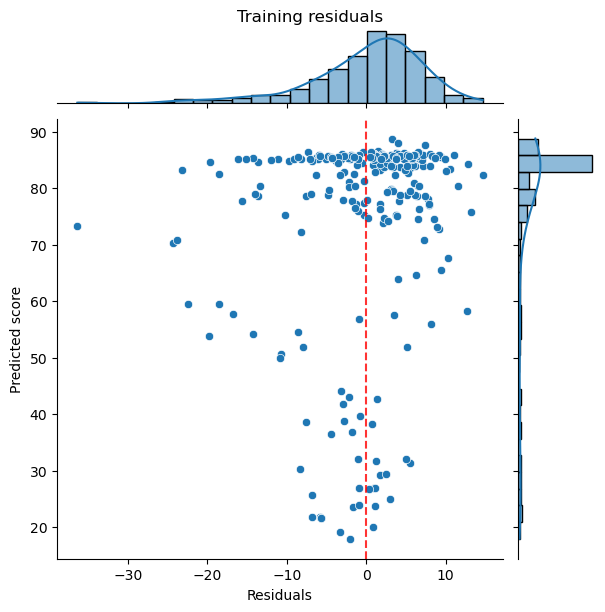

In [145]:
linreg_grid = sns.JointGrid(x=train_residuals, y=xgboost_y_hat_train)
linreg_grid.plot_joint(sns.scatterplot)
linreg_grid.plot_marginals(sns.histplot, kde=True)
linreg_grid.set_axis_labels(xlabel='Residuals', ylabel='Predicted score')

linreg_grid.ax_joint.axvline(x=0, color='red', linestyle='--', alpha=0.8)

linreg_grid.figure.subplots_adjust(top=0.95)
linreg_grid.figure.suptitle('Training residuals')

plt.show()

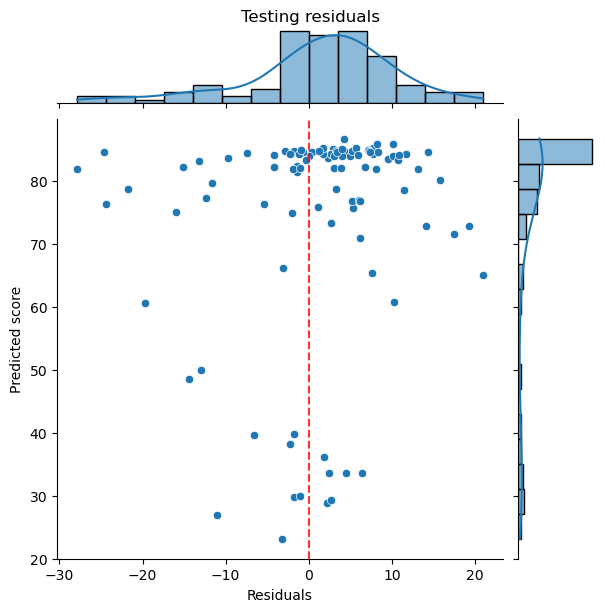

In [ ]:
linreg_grid = sns.JointGrid(x=test_residuals, y=xgb_y_hat_test)
linreg_grid.plot_joint(sns.scatterplot)
linreg_grid.plot_marginals(sns.histplot, kde=True)
linreg_grid.set_axis_labels(xlabel='Residuals', ylabel='Predicted score')

linreg_grid.ax_joint.axvline(x=0, color='red', linestyle='--', alpha=0.8)

linreg_grid.figure.subplots_adjust(top=0.95)
linreg_grid.figure.suptitle('Testing residuals')

plt.show()

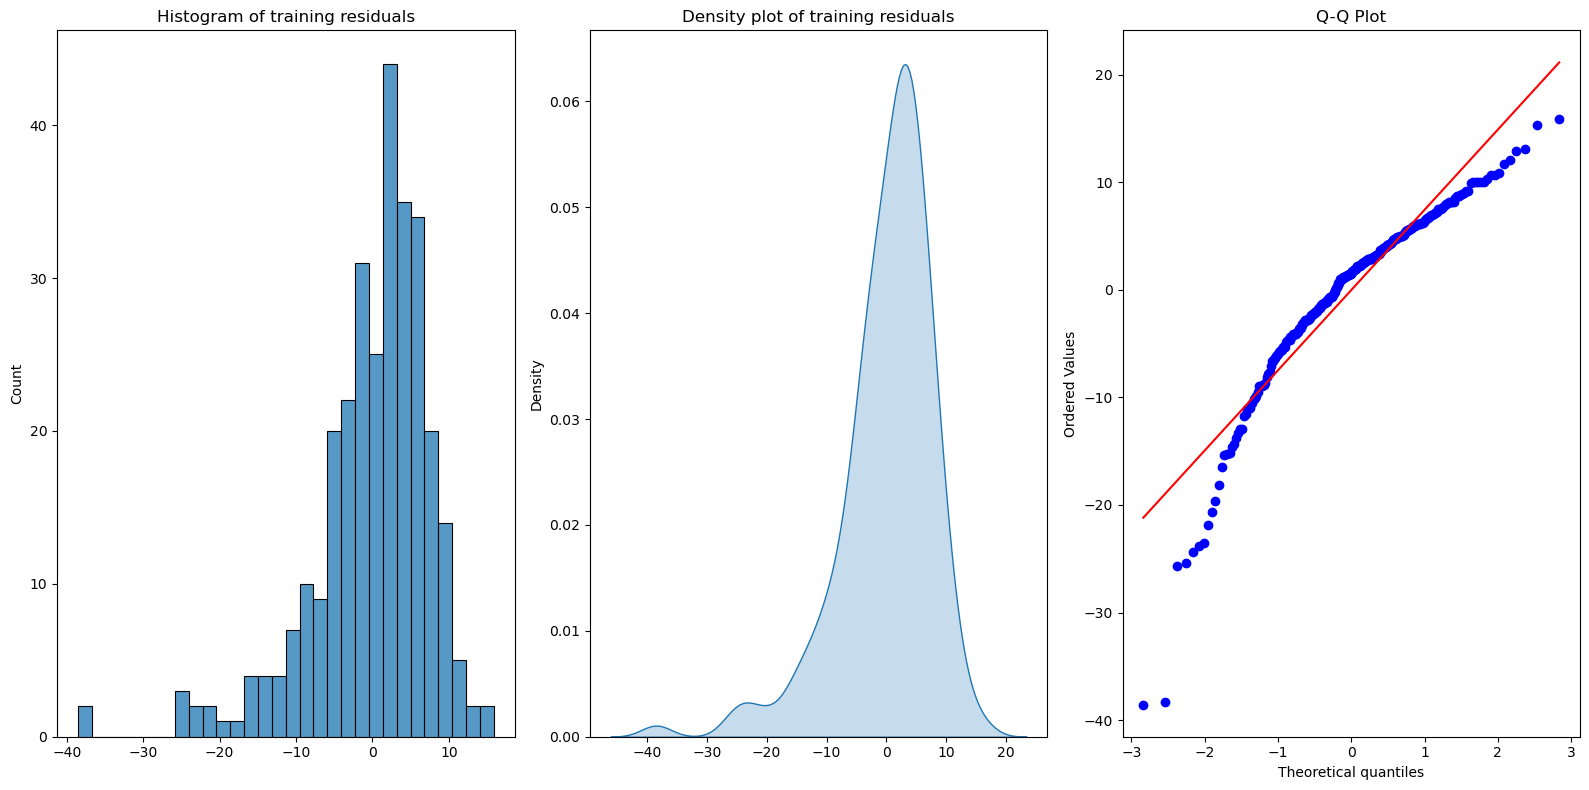

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

sns.histplot(x=train_residuals, bins=30, ax=axs[0])
axs[0].set_title('Histogram of training residuals')

sns.kdeplot(x=train_residuals, fill=True, ax=axs[1])
axs[1].set_title('Density plot of training residuals')

stats.probplot(train_residuals, dist="norm", plot=axs[2])
axs[2].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()